# **Kaggle Dataset**


In [8]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#unzip the file
#!unzip -q "/content/drive/MyDrive/ASL-Project/archive.zip" -d "/content/drive/MyDrive/ASL-Project" #zip path -d unzip path


In [10]:
import string
import cv2
import random
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:


def load_asl_alphabet_only(dataset_dir):
    """
    Loads only A–Y (excluding J and Z) from a dataset folder structure.

    Args:
        dataset_dir (str): Root directory containing subfolders.

    Returns:
        pd.DataFrame: DataFrame with image paths and filtered labels.
    """
    allowed_labels = [ch for ch in string.ascii_uppercase if ch not in ['J', 'Z']]
    data = []

    for label in sorted(os.listdir(dataset_dir)):
        label_path = os.path.join(dataset_dir, label)

        if not os.path.isdir(label_path) or label.upper() not in allowed_labels:
            continue

        for filename in os.listdir(label_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(label_path, filename)
                data.append({'file_path': full_path, 'label': label.upper()})

    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} images across {df['label'].nunique()} ASL alphabet classes (A–Y, no J/Z).")
    return df


In [12]:
dataset_path = "/content/drive/MyDrive/ASL-Project/asl-numbers-alphabet-dataset"
asl_df = load_asl_alphabet_only(dataset_path)

Loaded 72000 images across 24 ASL alphabet classes (A–Y, no J/Z).


In [13]:
def summarize_dataset(df, label_column='label', n_samples=6):
    """
    Prints basic summary statistics and insights about an image classification dataset.

    Args:
        df (pd.DataFrame): Dataset containing image file paths and labels.
        label_column (str): Column name for class labels. Default is 'label'.
    """
    total_images = len(df)
    num_classes = df[label_column].nunique()
    class_labels = sorted(df[label_column].unique())
    image_counts = df[label_column].value_counts().sort_index()

    print("===Dataset Summary====")
    print("-" * 30)
    print(f"Total images: {total_images}")
    print(f"Number of classes: {num_classes}")
    print(f"Class labels: {class_labels}")
    print("\nImage count per class:")
    print(image_counts)
    print("-" * 30)


    img_sample = cv2.imread(df.iloc[0]['file_path'], cv2.IMREAD_GRAYSCALE)
    if img_sample is not None:
        h, w = img_sample.shape
        print(f"Image dimensions (sample): {w} x {h}")
        print("-" * 30)

    # Show sample images
    sample_df = df.sample(n=min(n_samples, len(df)))
    fig, axes = plt.subplots(1, len(sample_df), figsize=(15, 4))

    for ax, (_, row) in zip(axes, sample_df.iterrows()):
        img = cv2.imread(row['file_path'], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Label: {row[label_column]}")
        else:
            ax.text(0.5, 0.5, "Image not found", ha='center', va='center')
        ax.axis('off')

    plt.suptitle("Random Sample Images", fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_class_distribution(df, label_column='label', title="ASL Class Distribution"):
    """
    Plots the number of images per class using a Seaborn barplot.

    Args:
        df (pd.DataFrame): DataFrame containing a column with class labels.
        label_column (str): Column name for class labels.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14, 6))
    ax = sns.countplot(data=df, x=label_column, palette='viridis', order=sorted(df[label_column].unique()))
    plt.title(title, fontsize=16)
    plt.xlabel("ASL Letter", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)

    # Annotate bar counts
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{height}", (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


===Dataset Summary====
------------------------------
Total images: 72000
Number of classes: 24
Class labels: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

Image count per class:
label
A    3000
B    3000
C    3000
D    3000
E    3000
F    3000
G    3000
H    3000
I    3000
K    3000
L    3000
M    3000
N    3000
O    3000
P    3000
Q    3000
R    3000
S    3000
T    3000
U    3000
V    3000
W    3000
X    3000
Y    3000
Name: count, dtype: int64
------------------------------
Image dimensions (sample): 224 x 224
------------------------------


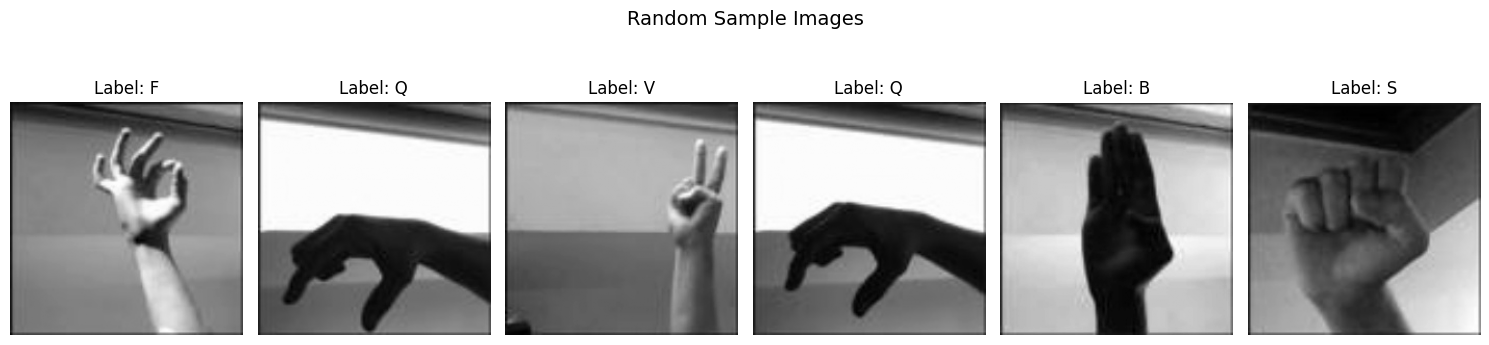

<ipython-input-13-2f19dd5f5285>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=label_column, palette='viridis', order=sorted(df[label_column].unique()))


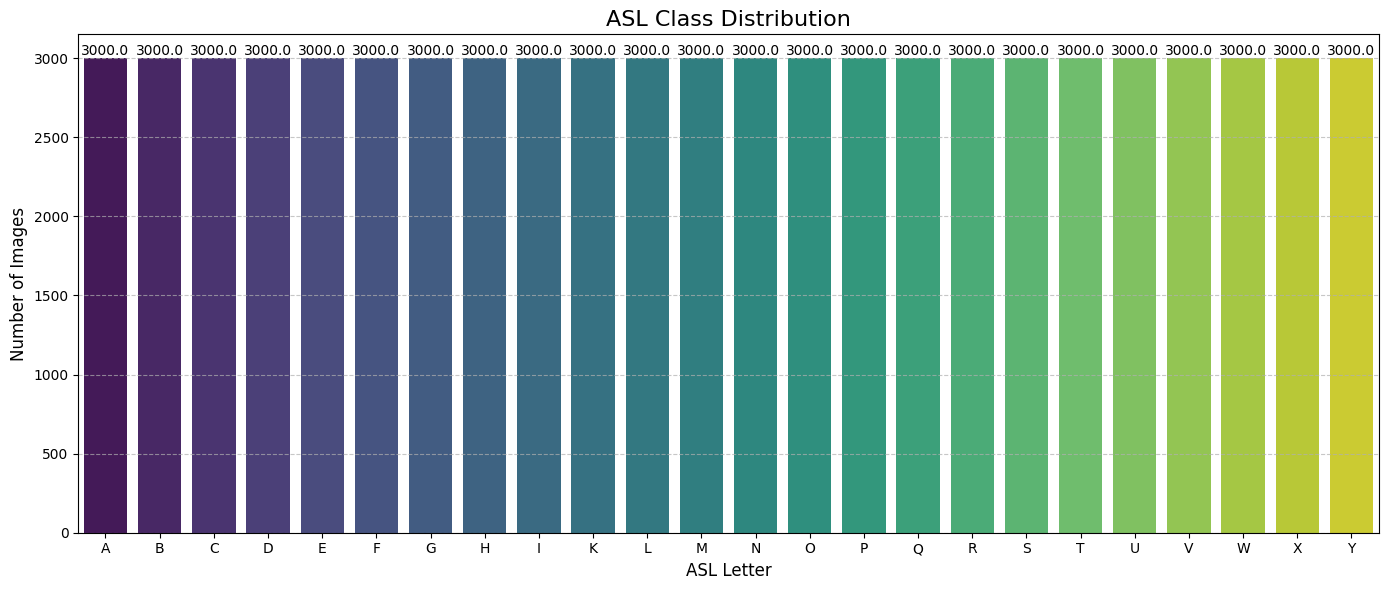

In [14]:
summarize_dataset(asl_df)
plot_class_distribution(asl_df)


In [15]:

def run_basic_eda(df, label_column='label', image_column='file_path', image_size=(224, 224)):
    """
    Performs essential EDA on an ASL image dataset.

    Args:
        df (pd.DataFrame): DataFrame with image paths and labels.
        label_column (str): Column containing class labels.
        image_column (str): Column containing image file paths.
        image_size (tuple): Desired image size (width, height) for processing.
    """

    # 1. Random sample per class
    unique_labels = sorted(df[label_column].unique())
    fig, axes = plt.subplots(4, 6, figsize=(16, 10))
    for i, label in enumerate(unique_labels):
        ax = axes[i // 6, i % 6]
        sample_row = df[df[label_column] == label].sample(1)
        img = cv2.imread(sample_row[image_column].values[0], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            ax.imshow(cv2.resize(img, image_size), cmap='gray')
            ax.set_title(f"{label}")
        ax.axis('off')
    plt.suptitle("Random Sample per Class", fontsize=16)
    plt.tight_layout()
    plt.show()

    # 2. Pixel intensity distribution
    print("Loading images for intensity analysis...")
    pixels = []
    for path in df[image_column].sample(n=min(500, len(df))):  # limit to 500 for speed
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, image_size)
            pixels.extend(img_resized.flatten())
    plt.figure(figsize=(10, 5))
    sns.histplot(pixels, bins=50, kde=True, color='gray')
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Value (0–255)")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # 3. Mean image
    print("Generating mean image...")
    image_stack = []
    for path in df[image_column].sample(n=min(200, len(df))):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, image_size)
            image_stack.append(img_resized.astype(np.float32))
    mean_image = np.mean(image_stack, axis=0)
    plt.figure(figsize=(6, 6))
    plt.imshow(mean_image, cmap='gray')
    plt.title("Mean Image")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def sample_n_per_class(df, label_column='label', n=100):
    """
    Returns a balanced subset with n samples per class.

    Args:
        df (pd.DataFrame): Dataset with labels and file paths.
        label_column (str): The column containing class labels.
        n (int): Number of samples per class.

    Returns:
        pd.DataFrame: Balanced subset.
    """
    return


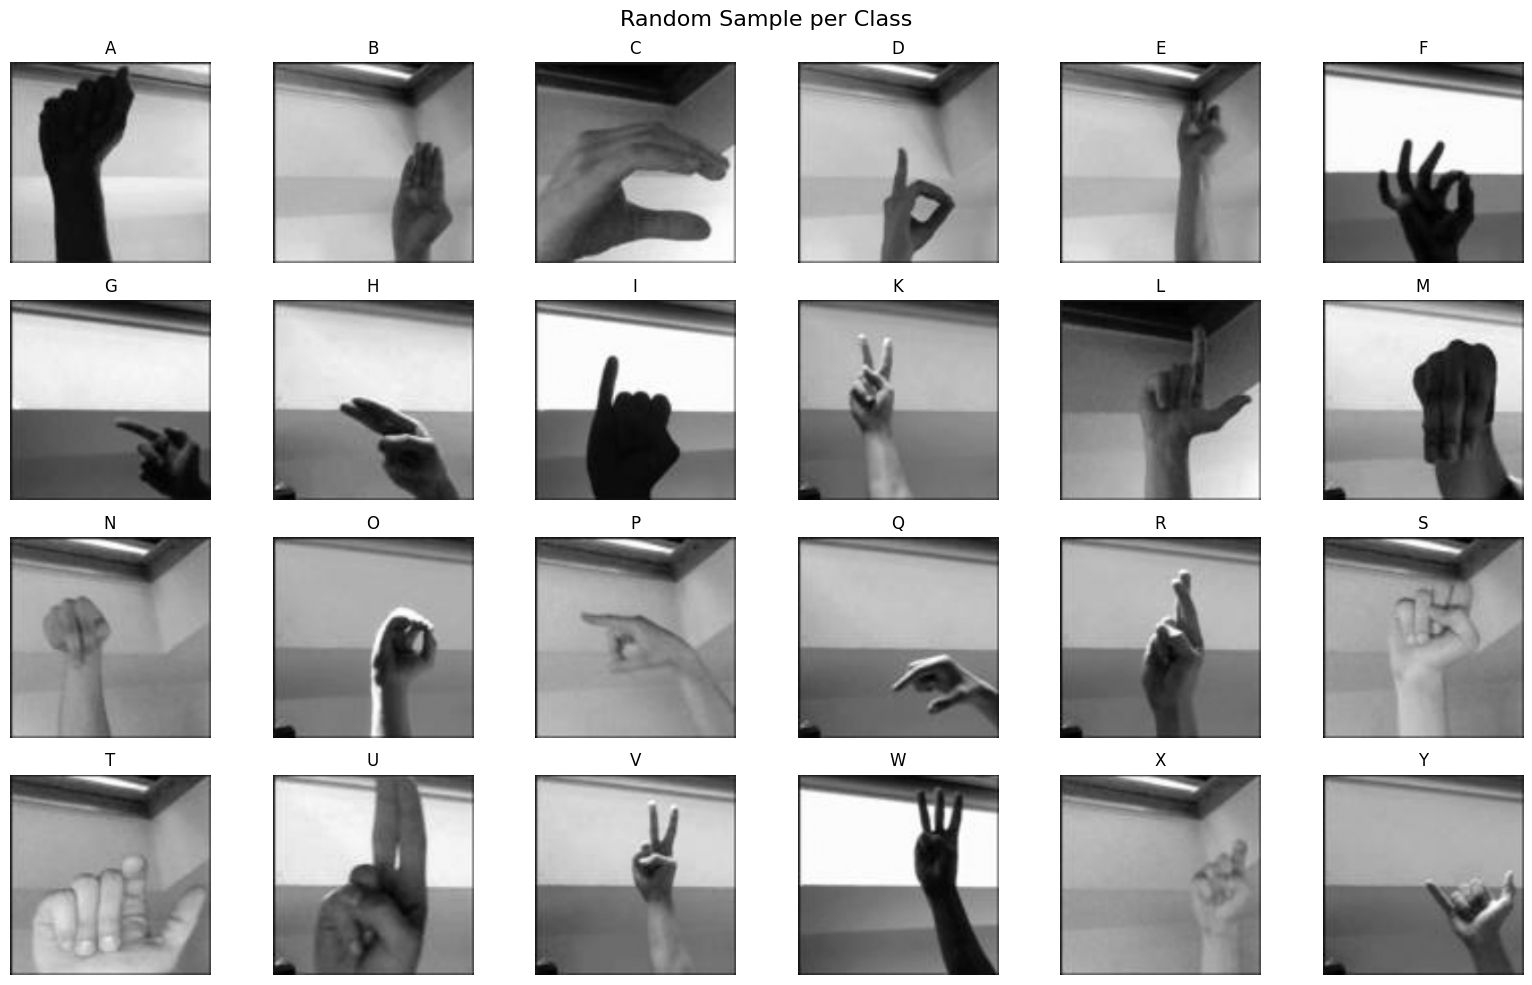

Loading images for intensity analysis...


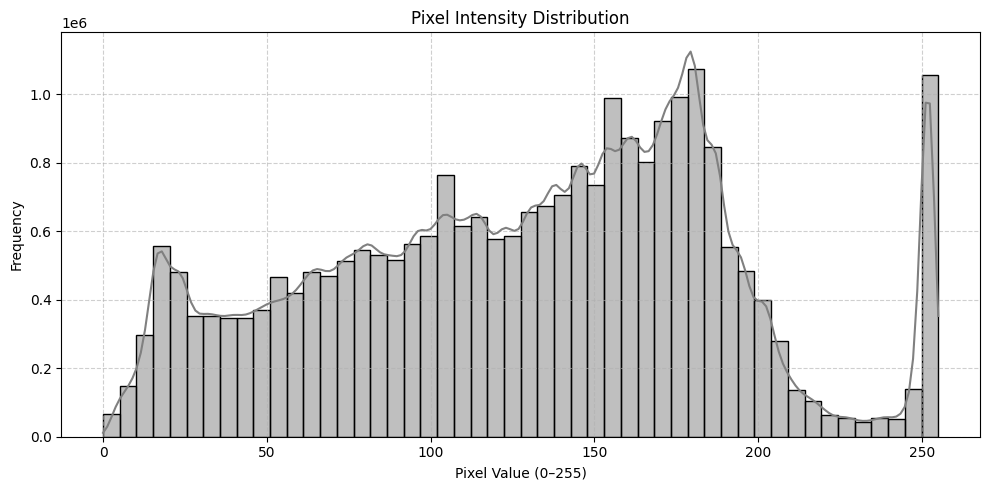

Generating mean image...


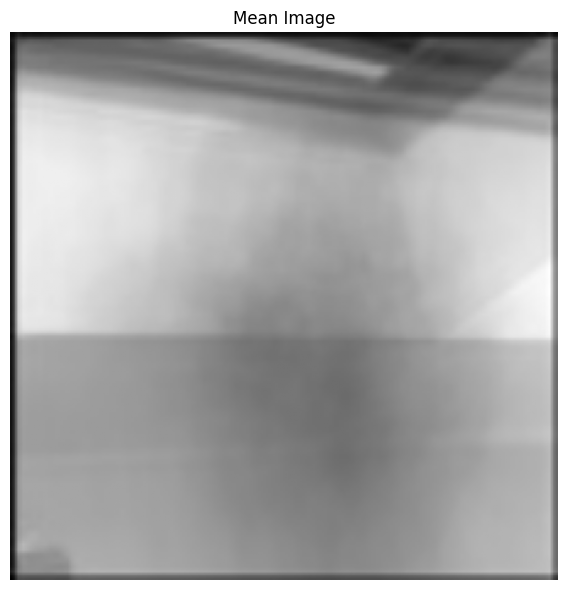

In [16]:
sample_df = asl_df.groupby('label').sample(n=100, random_state=42).reset_index(drop=True)
run_basic_eda(sample_df)

# **Roboflow Dataset**

In [17]:

# Reload the uploaded _classes.csv
csv_path = "/content/drive/MyDrive/ASL-Project/Roboflow/train/_classes.csv"
roboflow_classes_df = pd.read_csv(csv_path)

# Show the first few rows to understand structure
roboflow_classes_df.head()

filename   A   B   C   D   E   F  \
0   U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg   0   0   0   0   0   0   
1  P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg   0   0   0   0   0   0   
2   K4_jpg.rf.00821732715c9137b8060360770ea1d8.jpg   0   0   0   0   0   0   
3   W6_jpg.rf.00d19bc3a49f6469e2afa3aa92f14ff4.jpg   0   0   0   0   0   0   
4  J30_jpg.rf.00d20e595026b31773ded47509545471.jpg   0   0   0   0   0   0   

    G   H   I  ...   Q   R   S   T   U   V   W   X   Y   Z  
0   0   0   0  ...   0   0   0   0   1   0   0   0   0   0  
1   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
2   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
3   0   0   0  ...   0   0   0   0   0   0   1   0   0   0  
4   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 27 columns]

In [18]:
def load_roboflow_dataset(csv_path, images_dir):
    """
    Loads image paths and labels from Roboflow _classes.csv.
    Automatically handles extra whitespace in column names.

    Args:
        csv_path (str): Path to _classes.csv.
        images_dir (str): Directory where image files are stored.

    Returns:
        pd.DataFrame: DataFrame with ['file_path', 'label']
    """
    df = pd.read_csv(csv_path)

    # Strip spaces from column names
    df.columns = df.columns.str.strip()

    # Identify label columns (everything except 'filename')
    label_columns = [col for col in df.columns if col != 'filename']

    # Get label from one-hot encoding
    df['label'] = df[label_columns].idxmax(axis=1)

    # Build full image path
    df['file_path'] = df['filename'].apply(lambda x: os.path.join(images_dir, x))

    return df[['file_path', 'label']]


In [19]:
csv_path = "/content/drive/MyDrive/ASL-Project/Roboflow/train/_classes.csv"
images_dir = "/content/drive/MyDrive/ASL-Project/Roboflow/train"

roboflow_df = load_roboflow_dataset(csv_path, images_dir)


In [20]:

roboflow_df = roboflow_df[~roboflow_df['label'].isin(['J', 'Z'])]


===Dataset Summary====
------------------------------
Total images: 1368
Number of classes: 24
Class labels: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

Image count per class:
label
A    69
B    39
C    54
D    63
E    63
F    60
G    60
H    51
I    78
K    51
L    72
M    51
N    60
O    54
P    51
Q    60
R    48
S    69
T    42
U    48
V    57
W    57
X    63
Y    48
Name: count, dtype: int64
------------------------------
Image dimensions (sample): 390 x 390
------------------------------


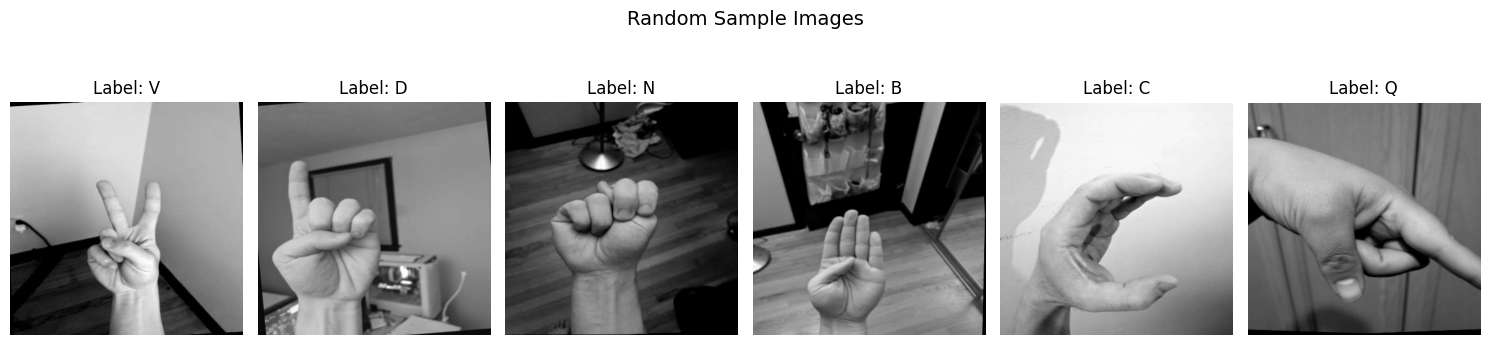

<ipython-input-13-2f19dd5f5285>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=label_column, palette='viridis', order=sorted(df[label_column].unique()))


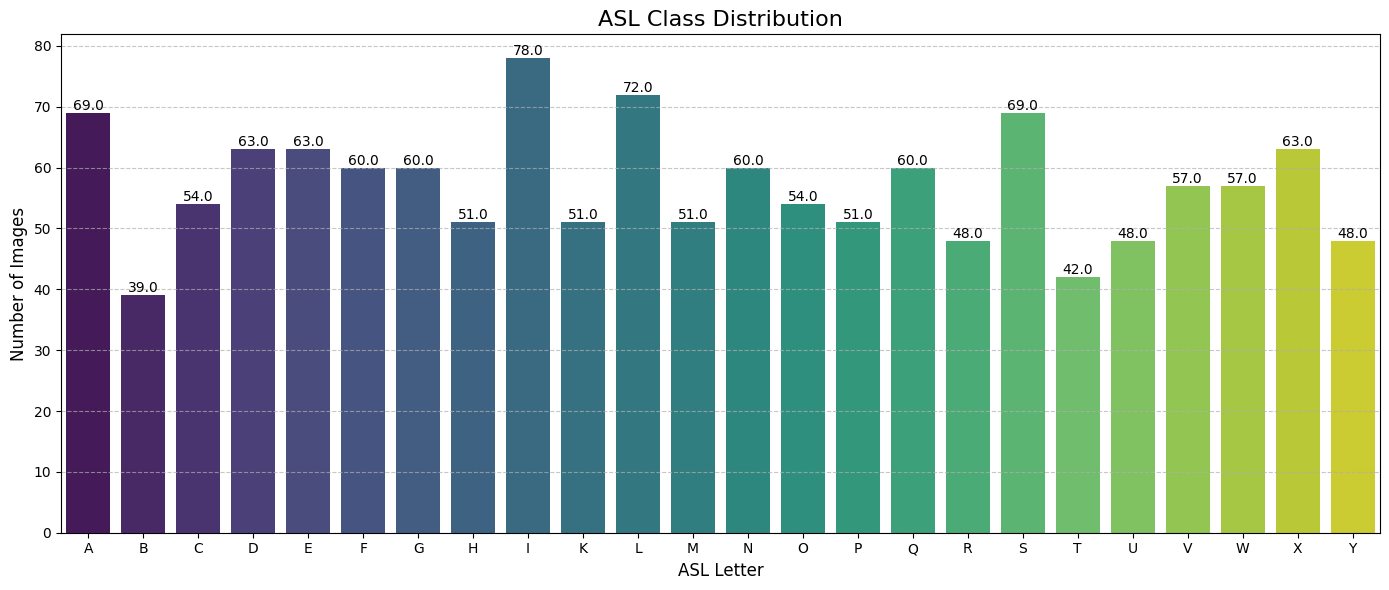

In [21]:
summarize_dataset(roboflow_df)
plot_class_distribution(roboflow_df)

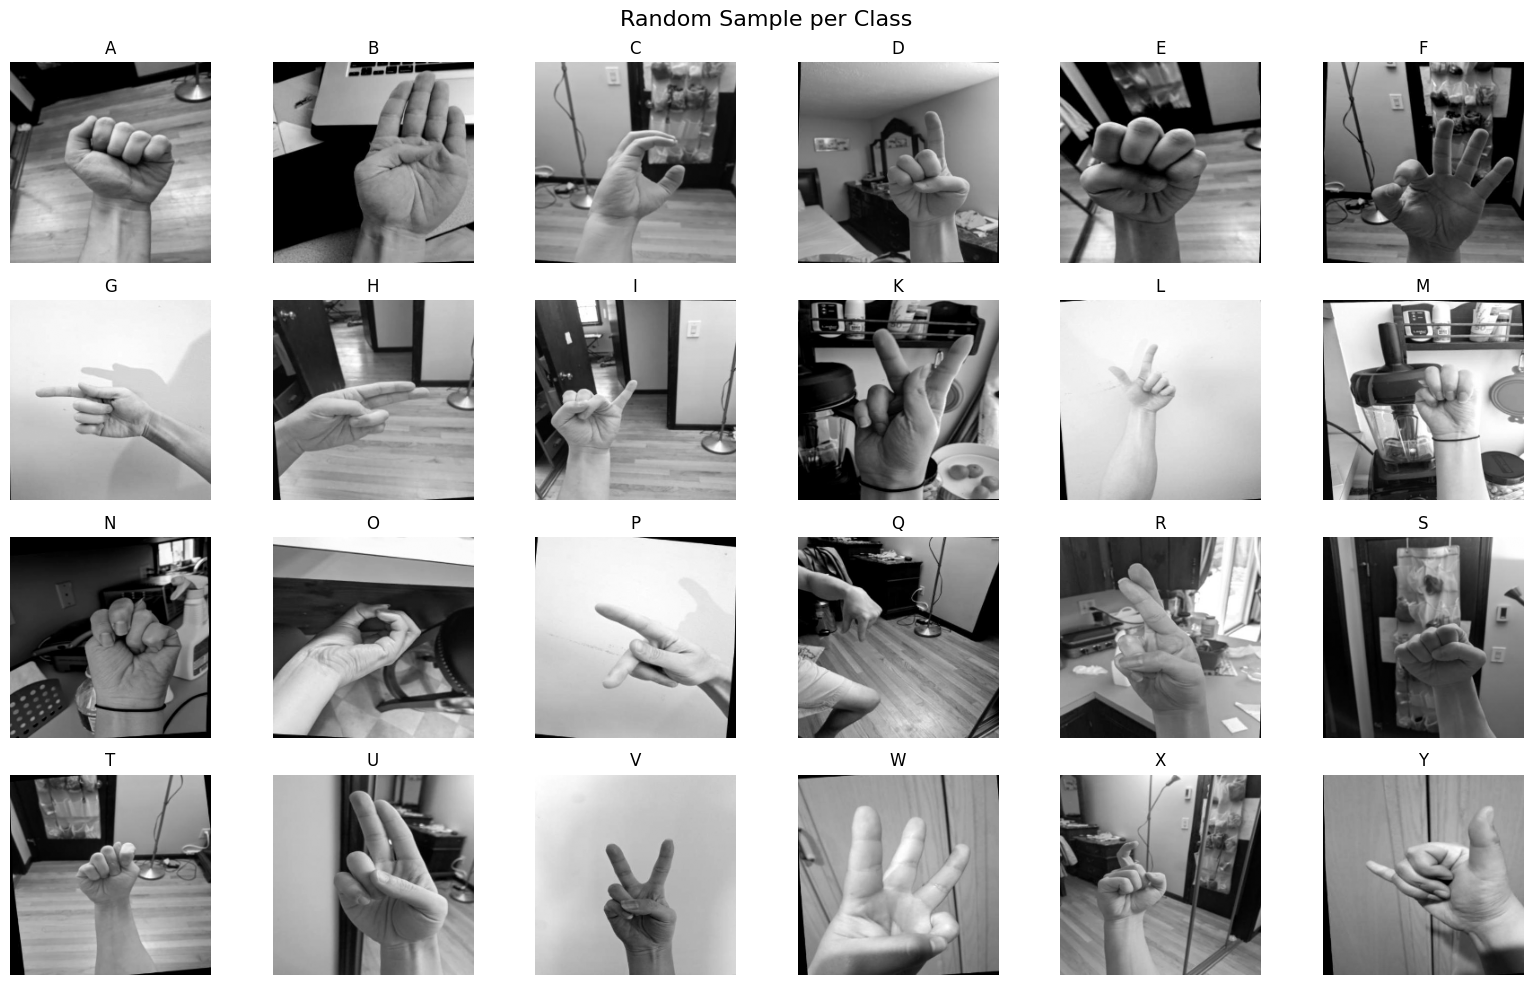

Loading images for intensity analysis...


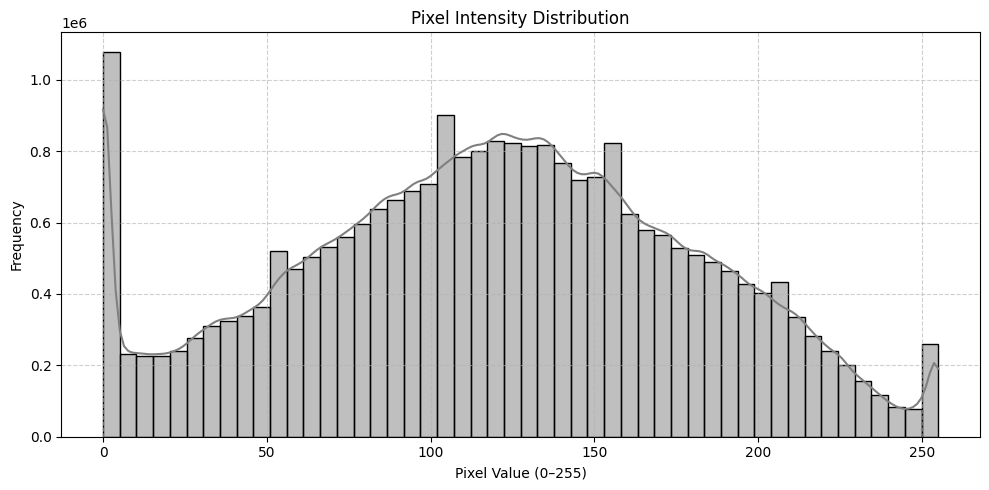

Generating mean image...


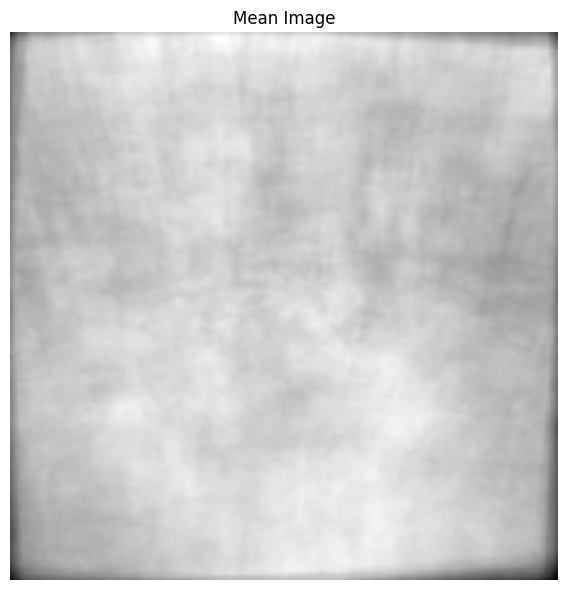

In [22]:
run_basic_eda(roboflow_df)

# **MNIST Dataset**

In [23]:

mnist_csv_path = "/content/drive/MyDrive/ASL-Project/MNIST/sign_mnist_train.csv"
mnist_df = pd.read_csv(mnist_csv_path)

# Show first few rows and column names
mnist_df.head(), mnist_df.columns[:10]


(   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
 0      3     107     118     127     134     139     143     146     150   
 1      6     155     157     156     156     156     157     156     158   
 2      2     187     188     188     187     187     186     187     188   
 3      2     211     211     212     212     211     210     211     210   
 4     13     164     167     170     172     176     179     180     184   
 
    pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
 0     153  ...       207       207       207       207       206       206   
 1     158  ...        69       149       128        87        94       163   
 2     187  ...       202       201       200       199       198       199   
 3     210  ...       235       234       233       231       230       226   
 4     185  ...        92       105       105       108       133       163   
 
    pixel781  pixel782  pixel783  pixel784  
 0       206   

In [33]:
def load_mnist_asl_mapped(csv_path):
    """
    Loads the MNIST ASL dataset from CSV and maps labels 0–23 to A–Y (excluding Z only).

    Args:
        csv_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame with 'label' and correctly mapped 'label_char'.
    """
    df = pd.read_csv(csv_path)

    # Only exclude Z, NOT J
    letters = [c for c in string.ascii_uppercase if c != 'Z']  # A–Y, including J

    # Map 0–23 to A–Y
    df['label_char'] = df['label'].map(lambda x: letters[x])

    return df



In [34]:
mnist_df = load_mnist_asl_mapped("/content/drive/MyDrive/ASL-Project/MNIST/sign_mnist_train.csv")



In [35]:
def summarize_mnist_asl(df, label_column='label_char'):
    """
    Prints a summary of MNIST-style ASL dataset including class distribution and sample image size.

    Args:
        df (pd.DataFrame): MNIST ASL DataFrame with pixel columns and label_char.
        label_column (str): Name of the column with mapped labels.
    """
    pixel_columns = [col for col in df.columns if col.startswith("pixel")]

    total_images = len(df)
    class_labels = sorted(df[label_column].unique())
    label_counts = df[label_column].value_counts().sort_index()
    sample_img_shape = df.loc[0, pixel_columns].values.reshape(28, 28).shape

    print("===Dataset Summary====")
    print("-" * 30)
    print(f"Total images: {total_images}")
    print(f"Number of classes: {len(class_labels)}")
    print(f"Class labels: {class_labels}\n")
    print("Image count per class:")
    print(label_counts)
    print("-" * 30)
    print(f"Image dimensions (sample): {sample_img_shape[1]} x {sample_img_shape[0]}")


In [36]:
mnist_df['label'].value_counts().sort_index()


label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: count, dtype: int64

In [37]:
summarize_mnist_asl(mnist_df)

===Dataset Summary====
------------------------------
Total images: 27455
Number of classes: 24
Class labels: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

Image count per class:
label_char
A    1126
B    1010
C    1144
D    1196
E     957
F    1204
G    1090
H    1013
I    1162
K    1114
L    1241
M    1055
N    1151
O    1196
P    1088
Q    1279
R    1294
S    1199
T    1186
U    1161
V    1082
W    1225
X    1164
Y    1118
Name: count, dtype: int64
------------------------------
Image dimensions (sample): 28 x 28


In [38]:
def run_mnist_eda(df, label_column='label_char', sample_size=100):
    """
    Runs EDA on MNIST ASL data with flattened grayscale pixels (28x28).

    Args:
        df (pd.DataFrame): The dataset with pixel columns and label_char.
        label_column (str): Column name for class labels.
        sample_size (int): Number of images to sample for pixel analysis.
    """
    pixel_columns = [col for col in df.columns if col.startswith("pixel")]

    # 1. Class distribution
    plt.figure(figsize=(14, 5))
    sns.countplot(data=df, x=label_column, palette='viridis', order=sorted(df[label_column].unique()))
    plt.title("Class Distribution")
    plt.xlabel("ASL Letter")
    plt.ylabel("Number of Images")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 2. One random image per class
    unique_labels = sorted(df[label_column].unique())
    fig, axes = plt.subplots(4, 6, figsize=(14, 10))
    for i, label in enumerate(unique_labels):
        ax = axes[i // 6, i % 6]
        sample = df[df[label_column] == label].sample(1)
        img = sample[pixel_columns].values.reshape(28, 28)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{label}")
        ax.axis('off')
    plt.suptitle("Random Sample per Class", fontsize=16)
    plt.tight_layout()
    plt.show()

    # 3. Pixel intensity histogram
    pixels = df[pixel_columns].sample(n=min(sample_size, len(df))).values.flatten()
    plt.figure(figsize=(10, 4))
    sns.histplot(pixels, bins=50, color='gray')
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Value (0–255)")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # 4. Mean image
    images = df[pixel_columns].sample(n=min(sample_size, len(df))).values.reshape(-1, 28, 28)
    mean_img = np.mean(images, axis=0)
    plt.figure(figsize=(5, 5))
    plt.imshow(mean_img, cmap='gray')
    plt.title("Mean Image")
    plt.axis('off')
    plt.tight_layout()
    plt.show()



<ipython-input-38-1a271cb95b43>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=label_column, palette='viridis', order=sorted(df[label_column].unique()))


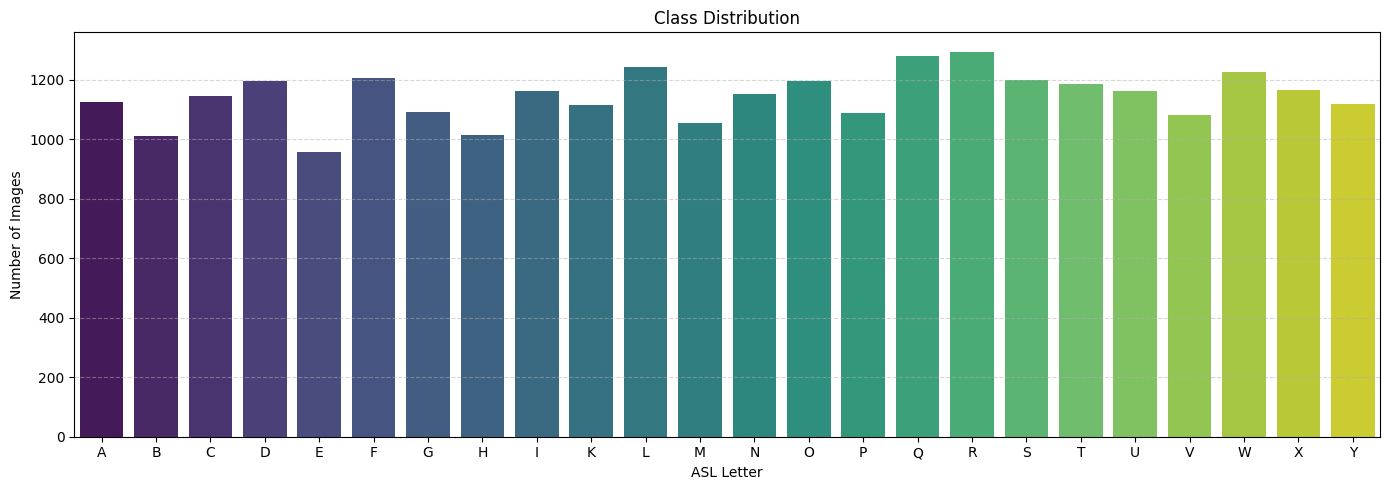

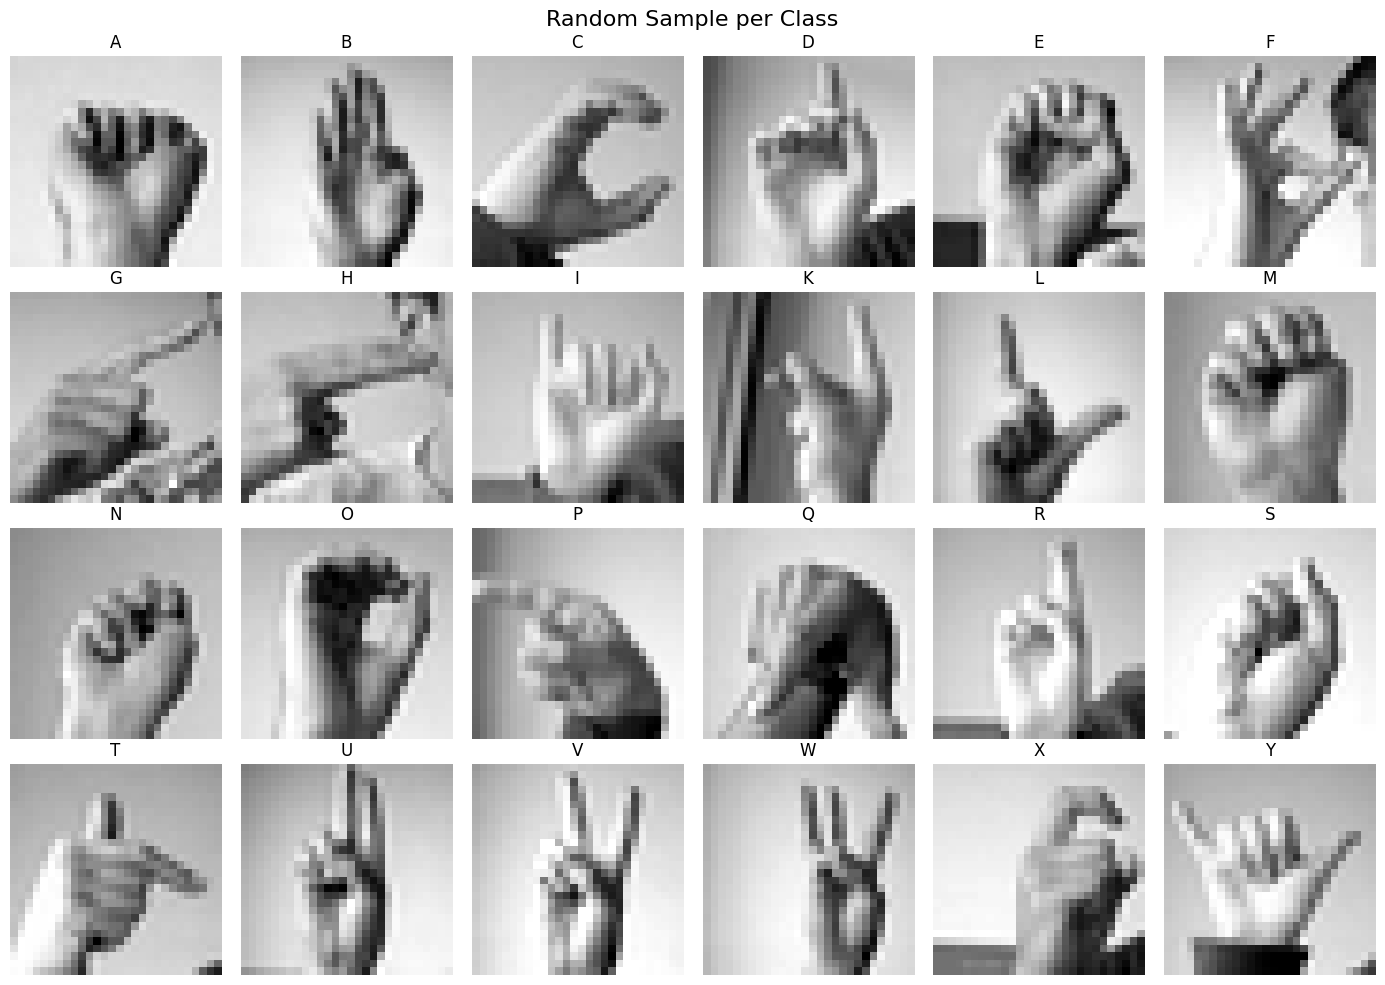

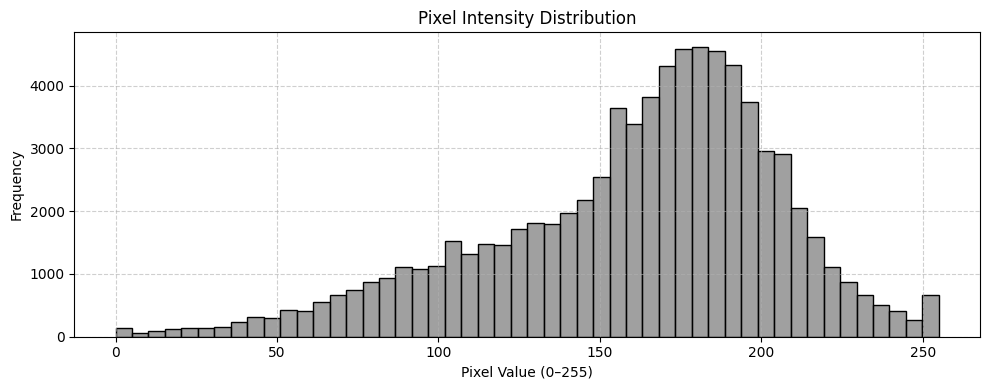

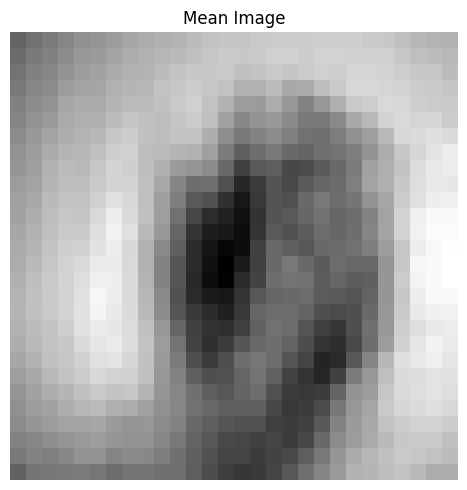

In [39]:
run_mnist_eda(mnist_df)

## **Merging Datasets**

In [53]:
def all_plot_class_distributions(kaggle_df, roboflow_df, mnist_df):
    """
    Plots class distributions of Kaggle, Roboflow, and MNIST ASL datasets side by side,
    and displays exact counts on each bar.
    """
    # Standardize label column names
    k = kaggle_df.copy()
    k['source'] = 'Kaggle'
    k['label'] = k['label']

    r = roboflow_df.copy()
    r['source'] = 'Roboflow'

    m = mnist_df.copy()
    m['source'] = 'MNIST'
    m['label'] = m['label_char']

    # Combine datasets
    all_data = pd.concat([k[['label', 'source']],
                          r[['label', 'source']],
                          m[['label', 'source']]])

    # Plot
    plt.figure(figsize=(18, 6))
    ax = sns.countplot(data=all_data, x='label', hue='source', palette='Set2')

    # Add count annotations
    for p in ax.patches:
        height = int(p.get_height())
        if height > 0:
            ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height + 5),
                        ha='center', va='bottom', fontsize=8)

    plt.title("Class Distribution Across Datasets")
    plt.xlabel("ASL Letter")
    plt.ylabel("Number of Images")
    plt.legend(title="Dataset")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


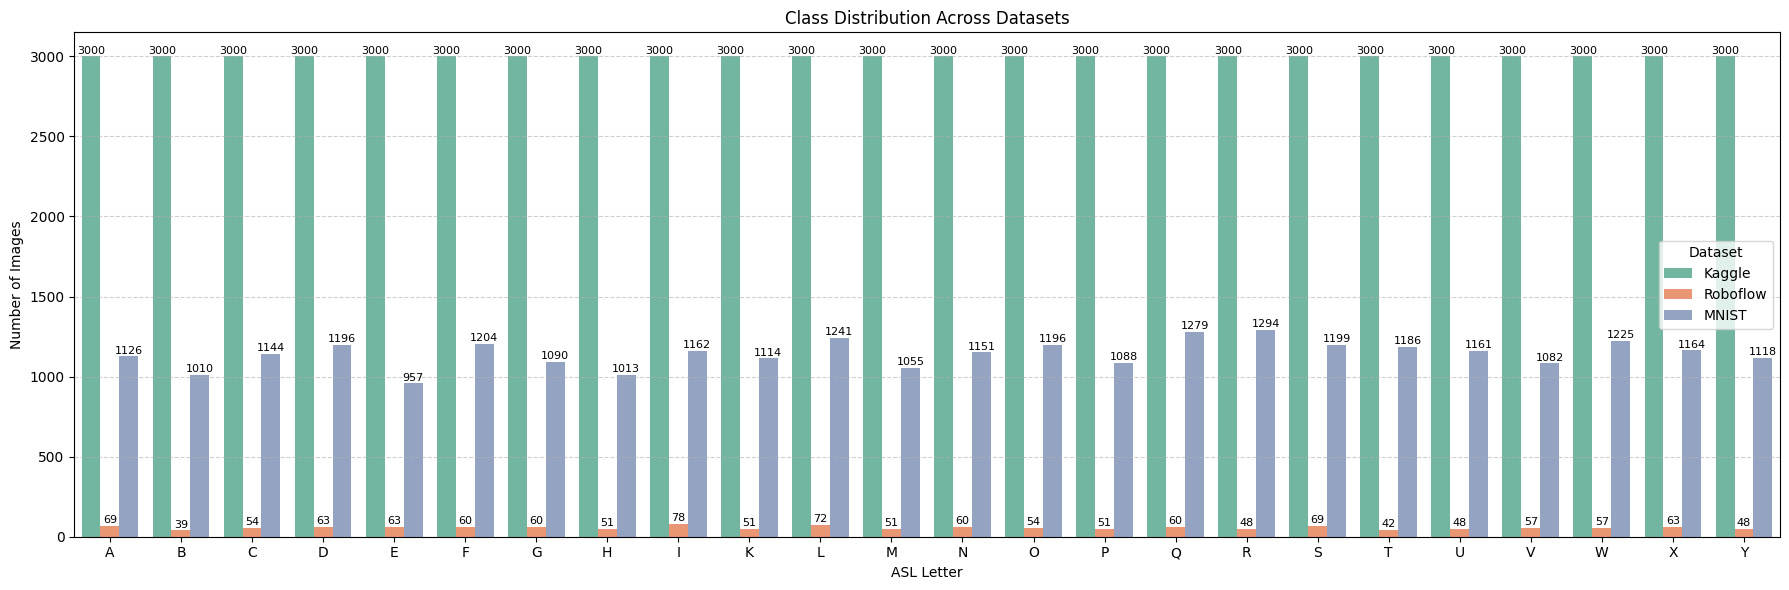

In [54]:
all_plot_class_distributions(asl_df, roboflow_df, mnist_df)


In [74]:
def plot_dataset_contribution():
    """
    Plots dataset contribution as percentage-based bar heights with
    image counts and per-class count labeled on top of each bar.
    """
    # Raw counts per dataset
    per_class = {
        'Roboflow': 30,
        'MNIST':    60,
        'Kaggle':   60
    }

    counts = {key: val * 24 for key, val in per_class.items()}  # 24 letters
    total = sum(counts.values())

    datasets = list(counts.keys())
    percentages = [v / total * 100 for v in counts.values()]
    raw_counts = list(counts.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(datasets, percentages, color=['#f28e2b', '#4e79a7', '#59a14f'])

    # Add label: total images + per-class
    for bar, count, name in zip(bars, raw_counts, datasets):
        height = bar.get_height()
        per_class_count = per_class[name]
        label = f"{count} imgs\n({per_class_count}/class)"
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1.5,
                 label, ha='center', va='bottom', fontsize=11)

    plt.title("Dataset Contribution to Master Grayscale Dataset")
    plt.ylabel("Percentage of Total Images")
    plt.ylim(0, 50)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


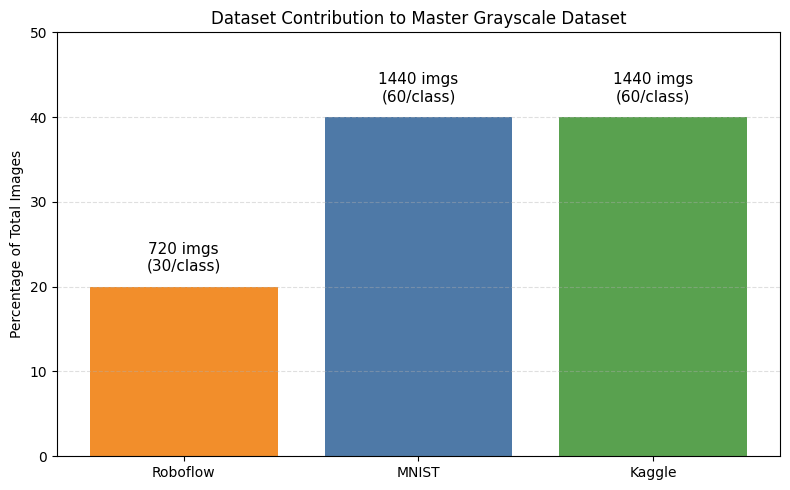

In [75]:
plot_dataset_contribution()


# **Creating Different Resolutions csvs**

In [82]:
def export_kaggle_grayscale_csv(kaggle_df, output_csv, samples_per_class=60, image_size=(28, 28)):
    """
    Samples images from Kaggle dataset, converts to grayscale 28x28, flattens, and saves to CSV.

    Args:
        kaggle_df (pd.DataFrame): DataFrame with 'file_path' and 'label_char' columns.
        output_csv (str): Path to save the resulting CSV.
        samples_per_class (int): Number of images to sample per class.
        image_size (tuple): Size to resize each image to.
    """
    df = kaggle_df.rename(columns={'label_char': 'label'})  # standardize label
    pixel_columns = [f'pixel{i+1}' for i in range(image_size[0] * image_size[1])]
    all_rows = []

    classes = sorted(df['label'].unique())

    for label in tqdm(classes, desc="Processing Kaggle classes"):
        samples = df[df['label'] == label].sample(samples_per_class, random_state=42)
        for path in samples['file_path']:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue  # skip unreadable images
            img = cv2.resize(img, image_size)
            row = [label] + img.flatten().tolist()
            all_rows.append(row)

    final_df = pd.DataFrame(all_rows, columns=['label'] + pixel_columns)
    final_df.to_csv(output_csv, index=False)
    print(f"Kaggle CSV saved to: {output_csv}")
    return final_df


In [83]:
output_csv = "/content/drive/MyDrive/ASL-Project/kaggle_grayscale_28x28.csv"
kaggle_sampled_df = export_kaggle_grayscale_csv(asl_df, output_csv)

Processing Kaggle classes: 100%|██████████| 24/24 [06:02<00:00, 15.12s/it]


Kaggle CSV saved to: /content/drive/MyDrive/ASL-Project/kaggle_grayscale_28x28.csv


In [89]:
export_kaggle_grayscale_csv(
    kaggle_df=asl_df,
    output_csv="/content/drive/MyDrive/ASL-Project/kaggle_64x64.csv",
    samples_per_class=60,
    image_size=(64, 64)
)


Processing Kaggle classes: 100%|██████████| 24/24 [00:08<00:00,  2.84it/s]


Kaggle CSV saved to: /content/drive/MyDrive/ASL-Project/kaggle_64x64.csv


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0        A      29      24      22      24      23      22      23      23   
1        A      30      25      24      25      25      22      24      25   
2        A      28      26      24      24      23      21      22      24   
3        A      33      39      38      37      44      44      44      47   
4        A      41      60      54      56      58      59      59      59   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
1435     Y      36      47      48      43      44      48      48      48   
1436     Y      39      47      48      47      43      42      41      42   
1437     Y      39      49      54      60      55      62      65      69   
1438     Y      37      51      56      52      54      61      62      67   
1439     Y      38      53      47      45      49      49      49      49   

      pixel9  ...  pixel4087  pixel4088  pixel4089  pixel4090  pixel4091  \
0         23  ...        156        156        156        158        161   
1         25  ...        160        162        162        164        166   
2         24  ...        161        161        160        161        163   
3         50  ...        119        118        118        118        118   
4         60  ...        120        118        119        118        118   
...      ...  ...        ...        ...        ...        ...        ...   
1435      49  ...         92         91         89         89         89   
1436      40  ...        111        110        109        108        109   
1437      71  ...         88         87         87         88         88   
1438      68  ...         74         81         83         83         83   
1439      49  ...         92         90         89         87         88   

      pixel4092  pixel4093  pixel4094  pixel4095  pixel4096  
0           161        162        166        169        118  
1           166        167        170        173        121  
2           167        168        170        174        122  
3           117        116        113        118         83  
4           121        123        125        133         94  
...         ...        ...        ...        ...        ...  
1435         91         93         93         91         70  
1436        109        109        107        113         82  
1437         87         87         85         85         66  
1438         82         82         83         79         61  
1439         89         91         91         90         72  

[1440 rows x 4097 columns]

In [91]:
export_kaggle_grayscale_csv(
    kaggle_df=asl_df,
    output_csv="/content/drive/MyDrive/ASL-Project/kaggle_224x224.csv",
    samples_per_class=60,
    image_size=(224, 224)
)


Processing Kaggle classes: 100%|██████████| 24/24 [00:11<00:00,  2.09it/s]


Kaggle CSV saved to: /content/drive/MyDrive/ASL-Project/kaggle_224x224.csv


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0        A      34      33      32      31      29      28      27      27   
1        A      33      33      32      31      30      30      29      29   
2        A      31      30      30      30      31      31      31      30   
3        A      28      29      35      40      35      30      29      28   
4        A      28      31      43      52      44      40      33      30   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
1435     Y      26      27      35      41      37      33      33      32   
1436     Y      30      34      38      44      36      30      28      29   
1437     Y      27      30      34      40      34      31      33      38   
1438     Y      27      30      36      42      37      36      38      44   
1439     Y      28      30      39      46      43      39      35      31   

      pixel9  ...  pixel50167  pixel50168  pixel50169  pixel50170  pixel50171  \
0         27  ...         139         142         143         144         143   
1         29  ...         142         146         148         147         147   
2         29  ...         142         145         147         146         148   
3         31  ...          98          97          96          99         102   
4         29  ...         107         108         109         112         116   
...      ...  ...         ...         ...         ...         ...         ...   
1435      34  ...          81          80          79          77          76   
1436      32  ...          94          92          91          95          97   
1437      37  ...          74          72          72          71          72   
1438      42  ...          70          71          71          69          66   
1439      31  ...          78          76          75          75          76   

      pixel50172  pixel50173  pixel50174  pixel50175  pixel50176  
0            149         156         126          89          77  
1            152         160         130          91          80  
2            152         158         129          93          81  
3            102         104          86          64          58  
4            115         117          98          74          66  
...          ...         ...         ...         ...         ...  
1435          79          85          70          53          47  
1436          98         101          83          63          56  
1437          75          81          67          51          45  
1438          70          74          63          48          44  
1439          80          86          72          57          51  

[1440 rows x 50177 columns]

In [94]:
def display_random_samples_from_csv(csv_path, image_size=(28, 28)):
    """
    Displays one random grayscale image per class from a MNIST-style CSV file.

    Args:
        csv_path (str): Path to the CSV file.
        image_size (tuple): Shape to reshape the flattened image (default is 28x28).
    """
    df = pd.read_csv(csv_path)
    pixel_columns = [col for col in df.columns if col.startswith("pixel")]
    classes = sorted(df['label'].unique())

    fig, axes = plt.subplots(4, 6, figsize=(14, 10))
    for i, label in enumerate(classes):
        ax = axes[i // 6, i % 6]
        sample = df[df['label'] == label].sample(1)
        img = sample[pixel_columns].values.reshape(image_size)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.suptitle("Random Sample from Each Class", fontsize=16)
    plt.tight_layout()
    plt.show()


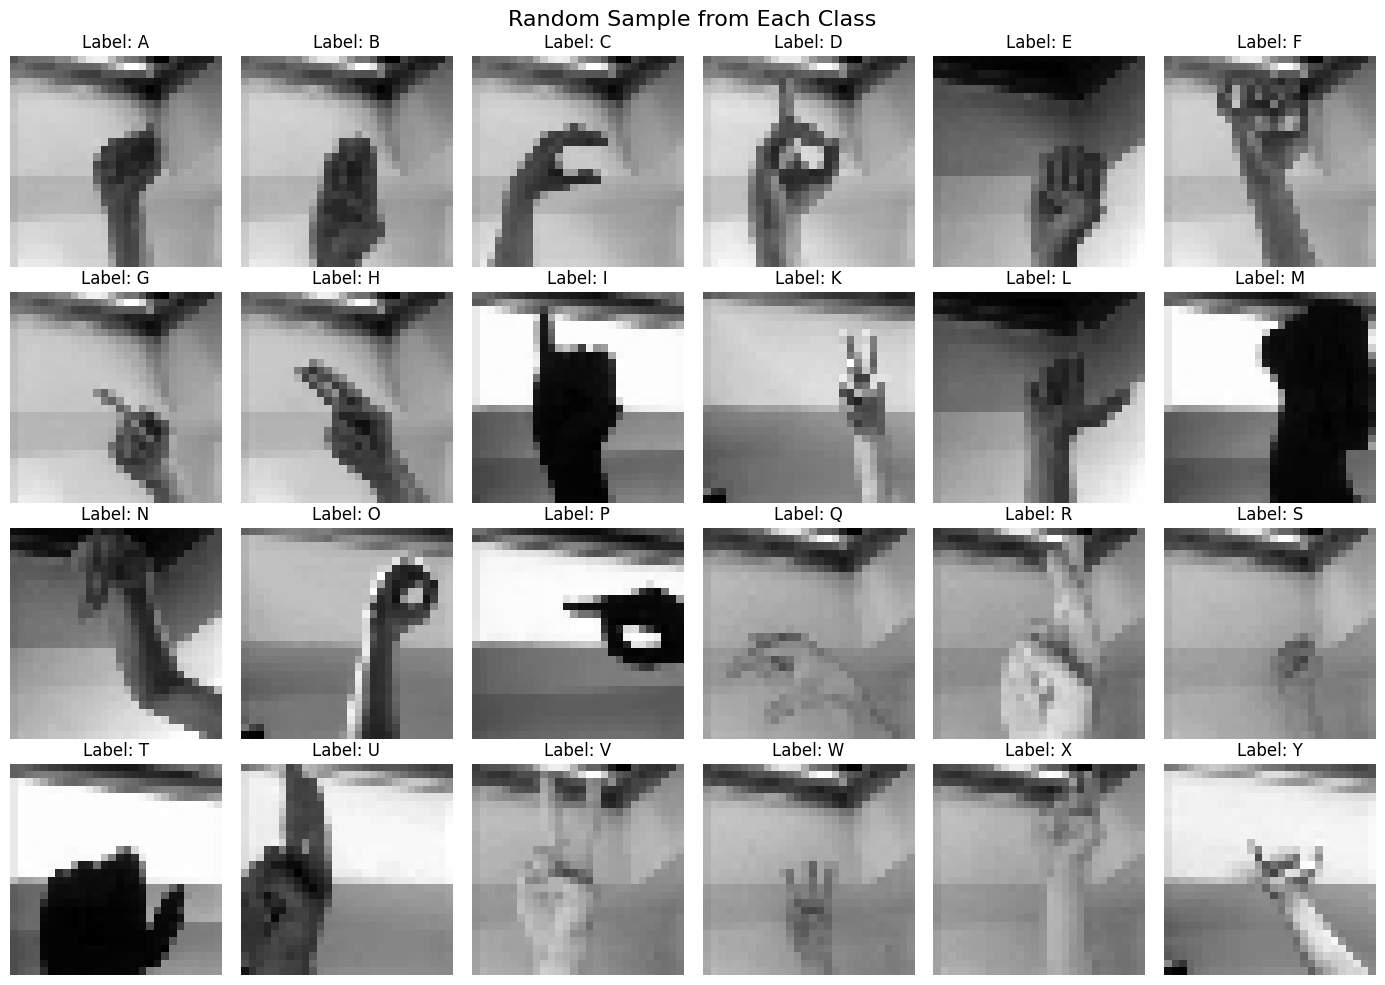

In [95]:
display_random_samples_from_csv("/content/drive/MyDrive/ASL-Project/kaggle_grayscale_28x28.csv")


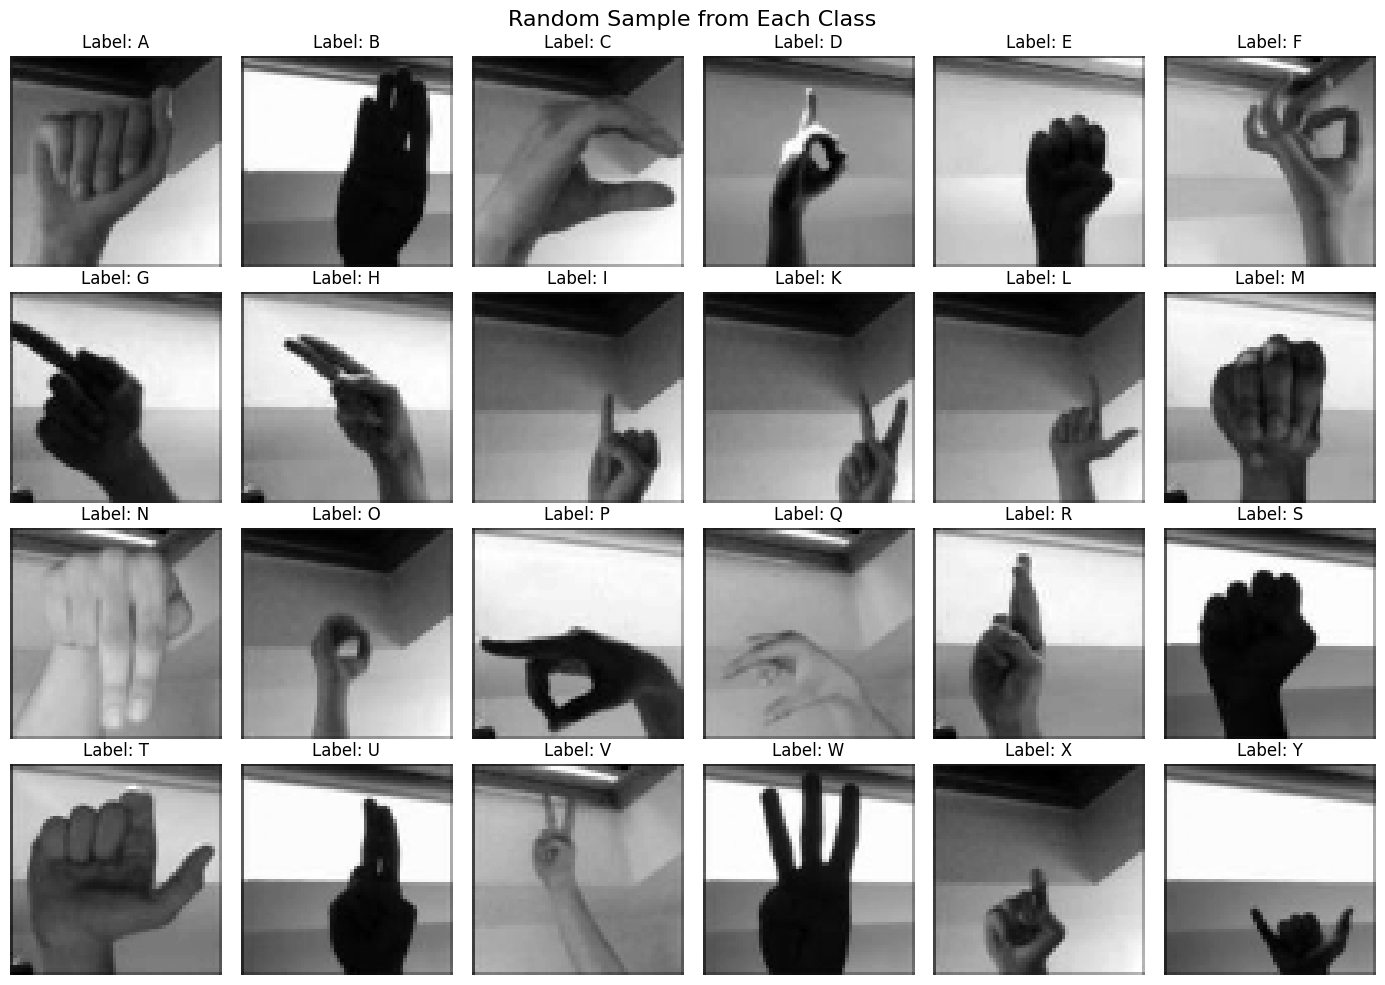

In [96]:
display_random_samples_from_csv("/content/drive/MyDrive/ASL-Project/kaggle_64x64.csv" ,image_size=(64, 64))


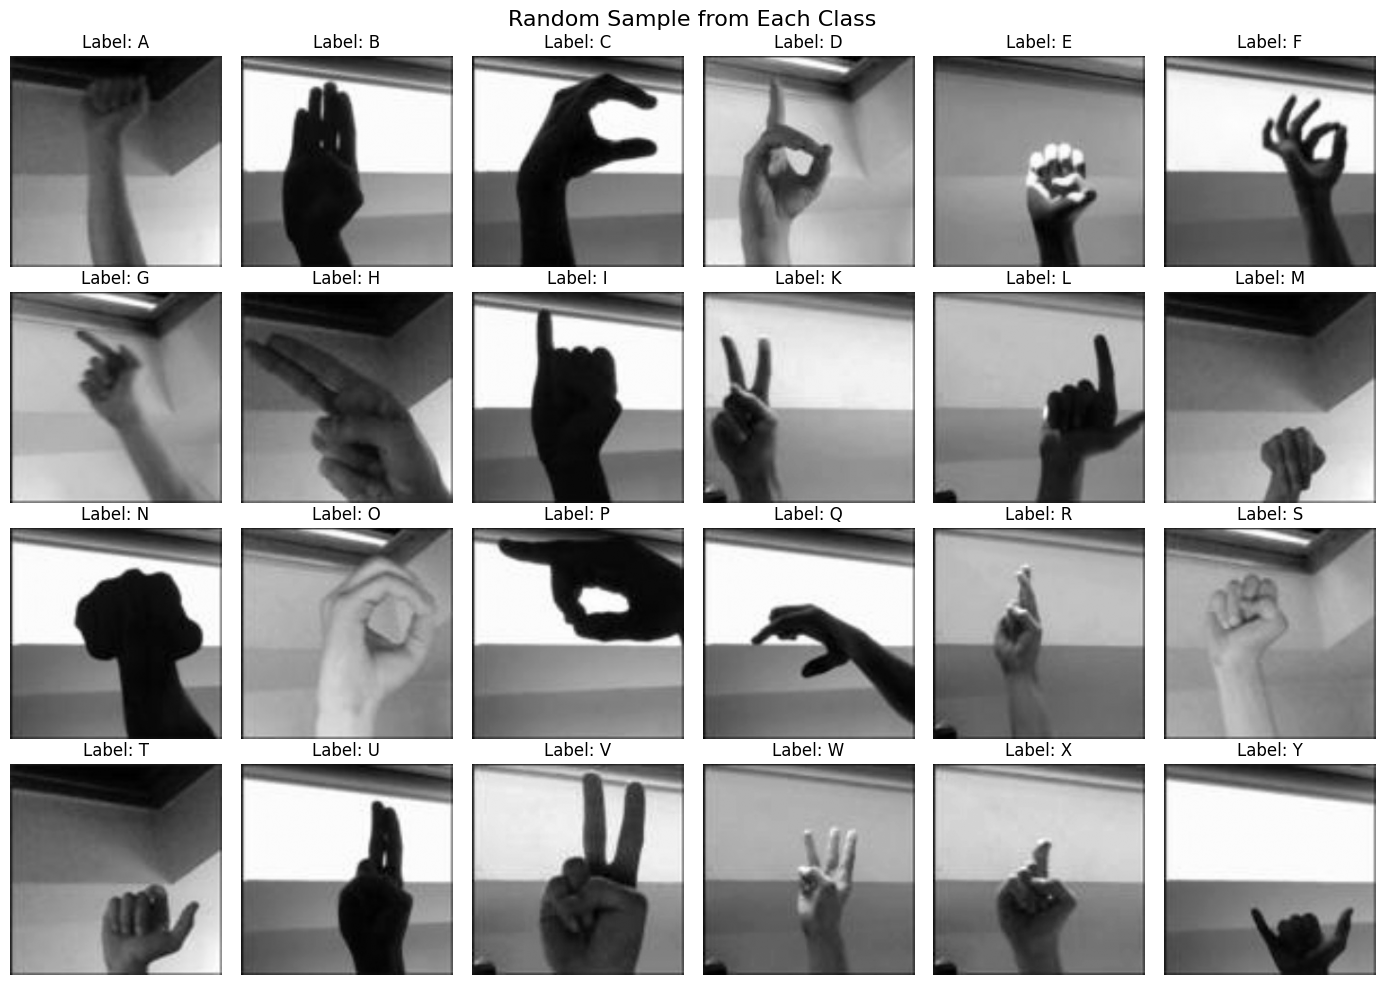

In [93]:
display_random_samples_from_csv("/content/drive/MyDrive/ASL-Project/kaggle_224x224.csv" ,image_size=(224, 224))


In [97]:
roboflow_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1368 entries, 0 to 1511
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  1368 non-null   object
 1   label      1368 non-null   object
dtypes: object(2)
memory usage: 32.1+ KB


In [103]:
export_kaggle_grayscale_csv(
    kaggle_df=roboflow_df,  # this works fine for Roboflow too
    output_csv="/content/drive/MyDrive/ASL-Project/roboflow_28x28.csv",
    samples_per_class=30,  # based on your balanced dataset plan
    image_size=(28, 28)
)


Processing Kaggle classes: 100%|██████████| 24/24 [00:04<00:00,  5.42it/s]


Kaggle CSV saved to: /content/drive/MyDrive/ASL-Project/roboflow_28x28.csv


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       A      49      32       4      44      53      63      70      76   
1       A     224     224     223     223     220     223     224     223   
2       A     101     100       0       0       0       0       0       0   
3       A      20      21      23      24      25      26      26      25   
4       A     180     187     187     187     187     186     190     189   
..    ...     ...     ...     ...     ...     ...     ...     ...     ...   
715     Y     183     183     183     183     182     182     181     180   
716     Y     141     140     139     142     142     143     143     142   
717     Y     199     135     155     203     201      75      65     173   
718     Y     137     132     131     135     134     135     131     135   
719     Y     190     187     187     191     188     190     194     194   

     pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0        80  ...       115         4         5        25        16        29   
1       222  ...       164       167       162       167       168       155   
2         0  ...        96         0         0         0         2         0   
3        20  ...        81        79        64        78        71        66   
4       189  ...       156       159       159       160       160       160   
..      ...  ...       ...       ...       ...       ...       ...       ...   
715     178  ...        86        85        85        85        85        85   
716     143  ...        99        96        93        89        85        81   
717      71  ...        86        97       108       118       102       109   
718     134  ...        97        98        97       101        98        98   
719     186  ...        51        51        51        51        51        51   

     pixel781  pixel782  pixel783  pixel784  
0          29        24        22        20  
1         154       154       156       155  
2           0         0         0         0  
3          32         9         4         0  
4         161       160       161       161  
..        ...       ...       ...       ...  
715        85        84        85        83  
716        76        69        67         1  
717        82        84        85        93  
718        97        96        93        93  
719        51        51        51        51  

[720 rows x 785 columns]

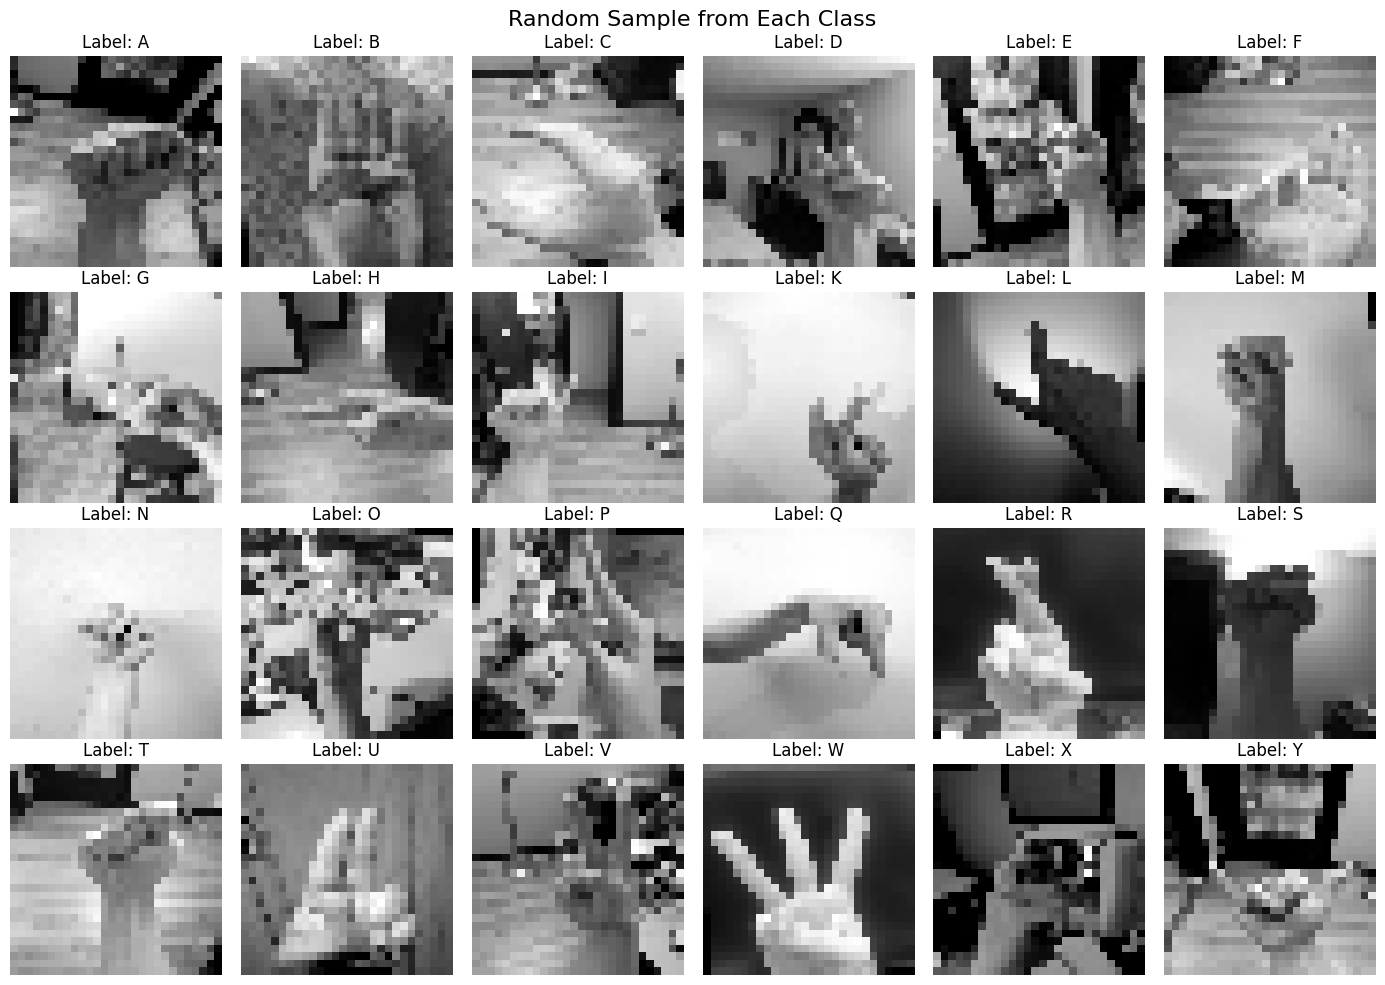

In [104]:
display_random_samples_from_csv("/content/drive/MyDrive/ASL-Project/roboflow_28x28.csv", image_size=(28, 28))

In [105]:
export_kaggle_grayscale_csv(
    kaggle_df=roboflow_df,  # this works fine for Roboflow too
    output_csv="/content/drive/MyDrive/ASL-Project/roboflow_64x64.csv",
    samples_per_class=30,  # based on your balanced dataset plan
    image_size=(64, 64)
)

Processing Kaggle classes: 100%|██████████| 24/24 [00:04<00:00,  5.19it/s]


Kaggle CSV saved to: /content/drive/MyDrive/ASL-Project/roboflow_64x64.csv


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       A      48      28       1      27       0       0      20      34   
1       A     225     225     225     225     225     224     224     224   
2       A     102     102     102      66       0       0       0       0   
3       A      21      23      22      21      22      24      21      21   
4       A      20     186     186     187     187     187     186     186   
..    ...     ...     ...     ...     ...     ...     ...     ...     ...   
715     Y      29     183     183     183     183     183     183     183   
716     Y     139     141     140     140     140     139     141     141   
717     Y     202     204     204     143      57     158     150     207   
718     Y     136     131     133     130     131     129     131     135   
719     Y     187     188     188     190     187     185     187     186   

     pixel9  ...  pixel4087  pixel4088  pixel4089  pixel4090  pixel4091  \
0        45  ...         30         31         30         27         25   
1       223  ...        153        152        153        155        154   
2         0  ...          0          0          0          0          0   
3        24  ...         66         59         33         13         15   
4       187  ...        158        160        162        160        160   
..      ...  ...        ...        ...        ...        ...        ...   
715     183  ...         84         84         85         85         85   
716     141  ...         78         74         71         69         67   
717     204  ...        109        109         99         83         85   
718     131  ...         96         96         96         96         95   
719     189  ...         51         51         51         51         51   

     pixel4092  pixel4093  pixel4094  pixel4095  pixel4096  
0           21         25         30         29         22  
1          155        154        155        155        157  
2            0          0          0          0          0  
3            2          1          1          1          0  
4          160        160        161        161        160  
..         ...        ...        ...        ...        ...  
715         85         85         85         85         85  
716         64         55          0          0          0  
717         87         91         94         89         94  
718         93         92         92         91         91  
719         51         51         51         51         51  

[720 rows x 4097 columns]

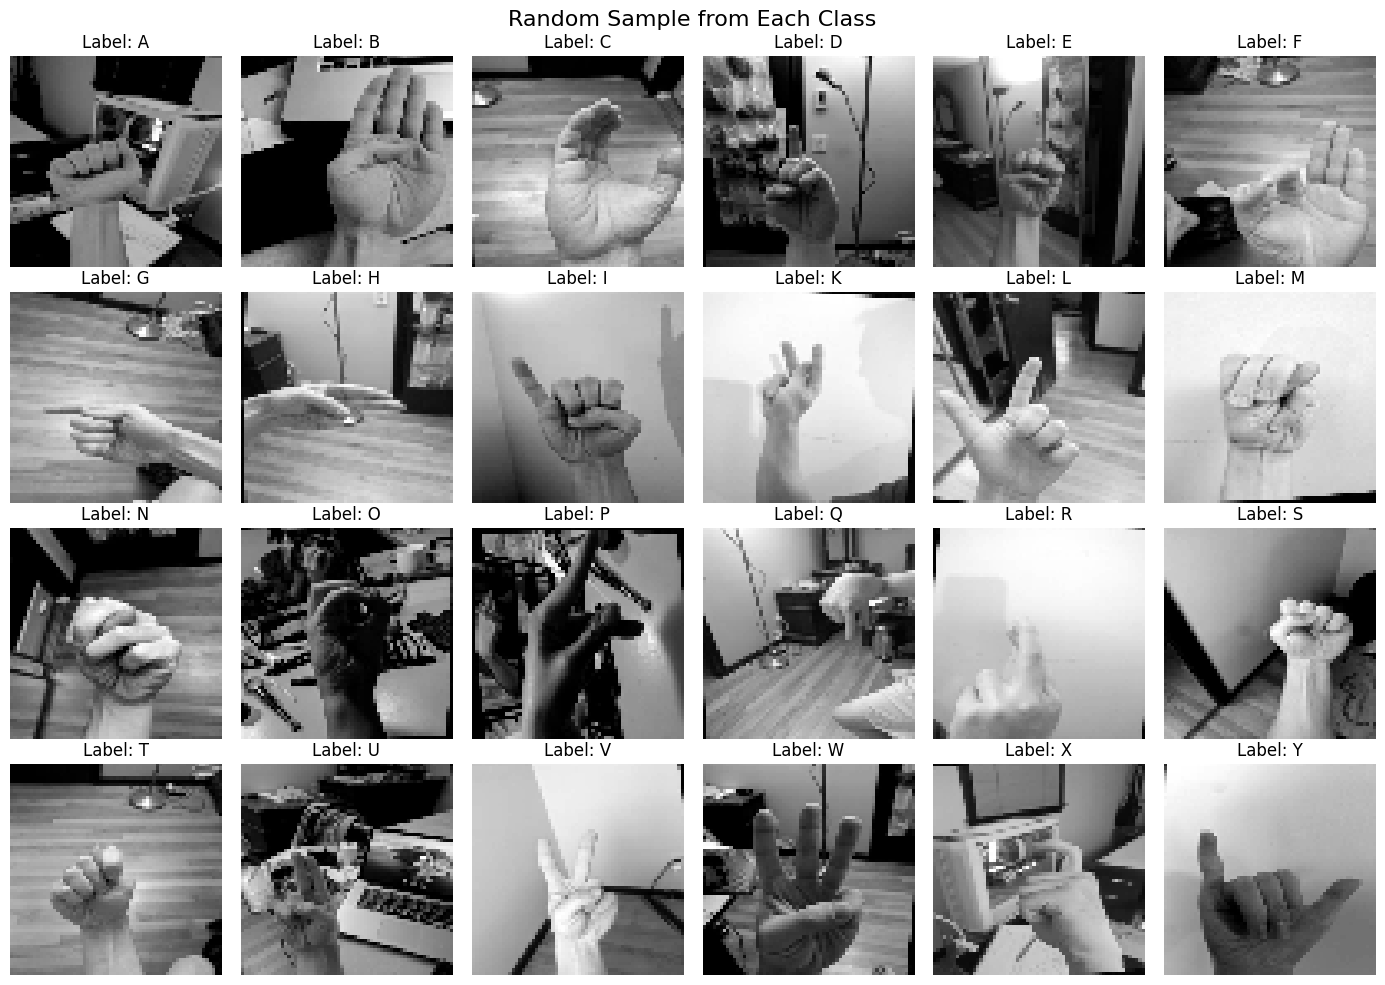

In [106]:
display_random_samples_from_csv("/content/drive/MyDrive/ASL-Project/roboflow_64x64.csv", image_size=(64, 64))

In [107]:
export_kaggle_grayscale_csv(
    kaggle_df=roboflow_df,  # this works fine for Roboflow too
    output_csv="/content/drive/MyDrive/ASL-Project/roboflow_224x224.csv",
    samples_per_class=30,  # based on your balanced dataset plan
    image_size=(224, 224)
)

Processing Kaggle classes: 100%|██████████| 24/24 [00:05<00:00,  4.39it/s]


Kaggle CSV saved to: /content/drive/MyDrive/ASL-Project/roboflow_224x224.csv


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       A      55      52      49      49      44      15       0       0   
1       A     226     226     226     226     226     226     226     226   
2       A     103     103     102     101     101     102     102     102   
3       A      15      17      18      17      17      17      16      16   
4       A      20      22      26     152     186     186     186     186   
..    ...     ...     ...     ...     ...     ...     ...     ...     ...   
715     Y       0       0     145     180     183     184     184     184   
716     Y     144     142     140     140     139     140     142     142   
717     Y     201     203     204     204     204     206     206     206   
718     Y     135     136     135     132     129     130     130     130   
719     Y     183     187     190     188     187     187     186     186   

     pixel9  ...  pixel50167  pixel50168  pixel50169  pixel50170  pixel50171  \
0         1  ...          27          29          29          30          32   
1       226  ...         152         154         154         154         154   
2       102  ...           0           0           0           0           0   
3        17  ...           4           4           3           3           3   
4       186  ...         159         159         157         158         161   
..      ...  ...         ...         ...         ...         ...         ...   
715     184  ...          85          85          85          85          85   
716     139  ...           1           1           0           0           0   
717     206  ...          89          90          92          95          94   
718     132  ...          92          93          92          91          92   
719     187  ...          51          51          51          51          51   

     pixel50172  pixel50173  pixel50174  pixel50175  pixel50176  
0            32          31          27          23           0  
1           153         152         154         155         154  
2             0           0           0           0           0  
3             2           2           0           0           0  
4           161         160         160         160         160  
..          ...         ...         ...         ...         ...  
715          85          85          85          85          85  
716           0           0           0           0           0  
717          95          94          89          88          88  
718          89          90          90          88          88  
719          51          51          51          51          51  

[720 rows x 50177 columns]

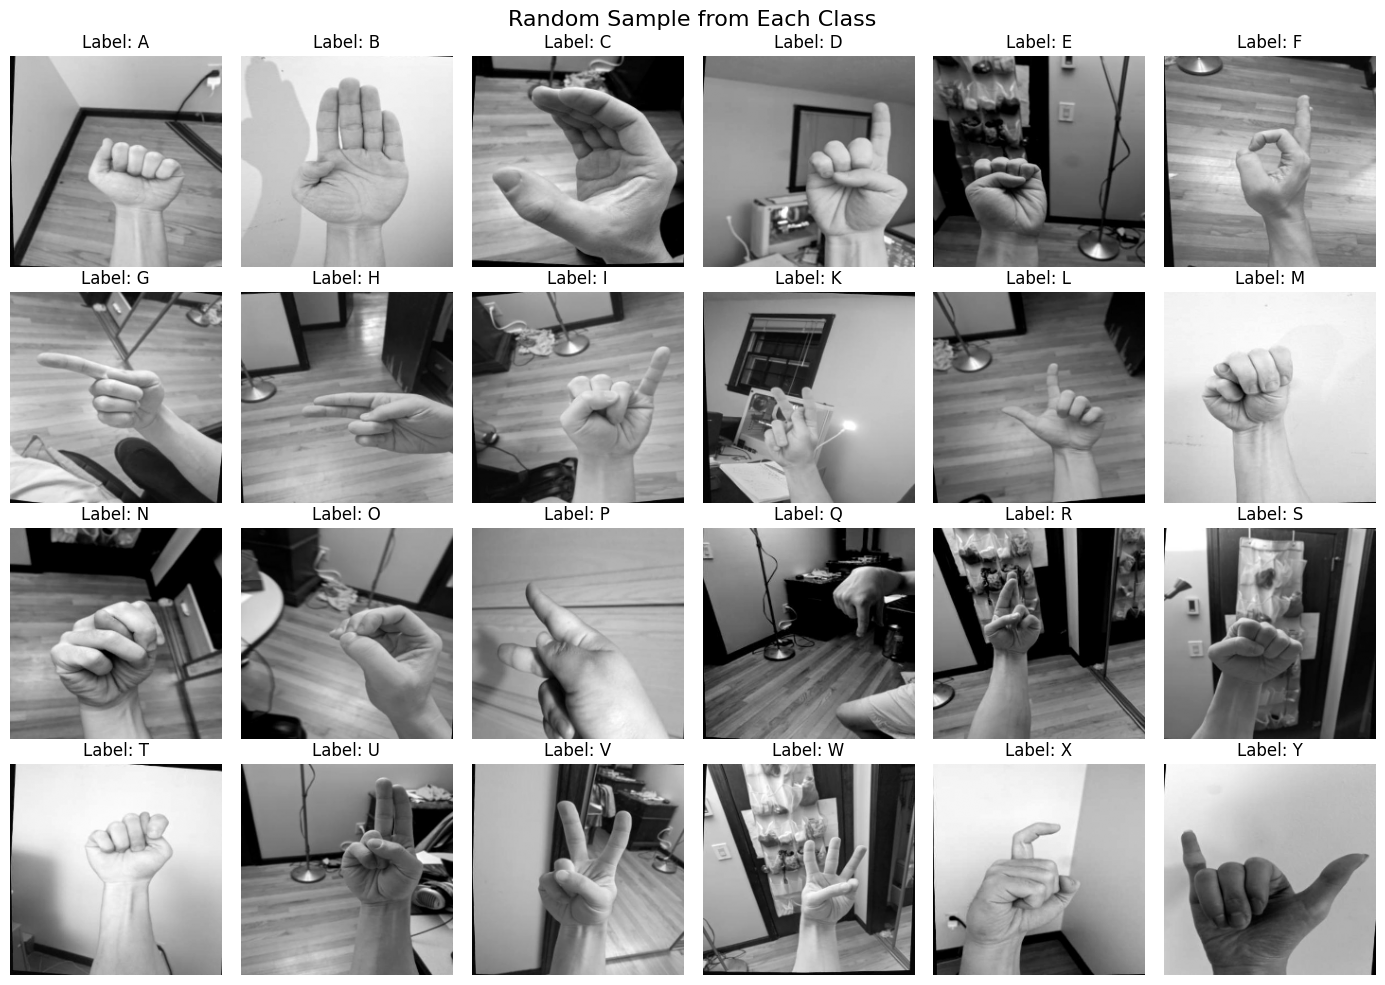

In [108]:
display_random_samples_from_csv("/content/drive/MyDrive/ASL-Project/roboflow_224x224.csv", image_size=(224, 224))

In [116]:
def export_resized_mnist_csv(mnist_df, output_csv, samples_per_class=60, image_size=(28, 28)):
    """
    Resizes flattened MNIST-style images to new resolution, flattens again, and saves as CSV.
    """
    # Safe copy + fix column selection
    df = mnist_df.copy()
    df = df[['label_char'] + [col for col in df.columns if col.startswith("pixel")]]
    df = df.rename(columns={'label_char': 'label'})  # ensure single label column

    resized_rows = []

    for label, group in df.groupby('label'):
        samples = group.sample(n=samples_per_class, random_state=42)
        for _, row in samples.iterrows():
            img_28 = row.drop('label').values.reshape(28, 28).astype(np.uint8)
            resized = cv2.resize(img_28, image_size)
            resized_rows.append([label] + resized.flatten().tolist())

    pixel_columns = [f'pixel{i+1}' for i in range(image_size[0] * image_size[1])]
    final_df = pd.DataFrame(resized_rows, columns=['label'] + pixel_columns)
    final_df.to_csv(output_csv, index=False)
    print(f"Resized MNIST CSV saved to: {output_csv}")
    return final_df


In [117]:
export_resized_mnist_csv(mnist_df, "/content/drive/MyDrive/ASL-Project/mnist_28x28.csv", samples_per_class=60, image_size=(28, 28))


Resized MNIST CSV saved to: /content/drive/MyDrive/ASL-Project/mnist_28x28.csv


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0        A     181     181     181     180     180     180     180     179   
1        A     188     188     190     192     193     195     196     198   
2        A     218     220     223     224     226     227     228     228   
3        A     174     176     176     175     177     177     178     178   
4        A     173     175     175     175     176     178     178     178   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
1435     Y     136     140     144     148     151     153     157     159   
1436     Y     170     171     173     174     177     179     181     182   
1437     Y     104     109     111     115     119     124     127     129   
1438     Y     188     189     190     192     195     196     197     198   
1439     Y     141     143     145     149     150     150     152     153   

      pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0        179  ...       188       187       186       185       184       182   
1        200  ...        79        61       163       243       229       232   
2        228  ...       189       191       194       195       178       130   
3        177  ...       212       204       204       203       203       203   
4        177  ...       109       206       216       214       219       204   
...      ...  ...       ...       ...       ...       ...       ...       ...   
1435     159  ...        99        97        97        97       105       149   
1436     184  ...       209       203       205       206       206       206   
1437     133  ...        85        82        82        81        79        78   
1438     198  ...       148       126       103       192       221       214   
1439     155  ...        53        12       133       197       184       185   

      pixel781  pixel782  pixel783  pixel784  
0          182       181       179       177  
1          232       233       232       232  
2          138       155        65        33  
3          202       205       203       201  
4          197       205       217       215  
...        ...       ...       ...       ...  
1435       197       192       179       156  
1436       207       207       206       206  
1437        78        79        76        75  
1438       214       211       211       210  
1439       182       179       176       175  

[1440 rows x 785 columns]

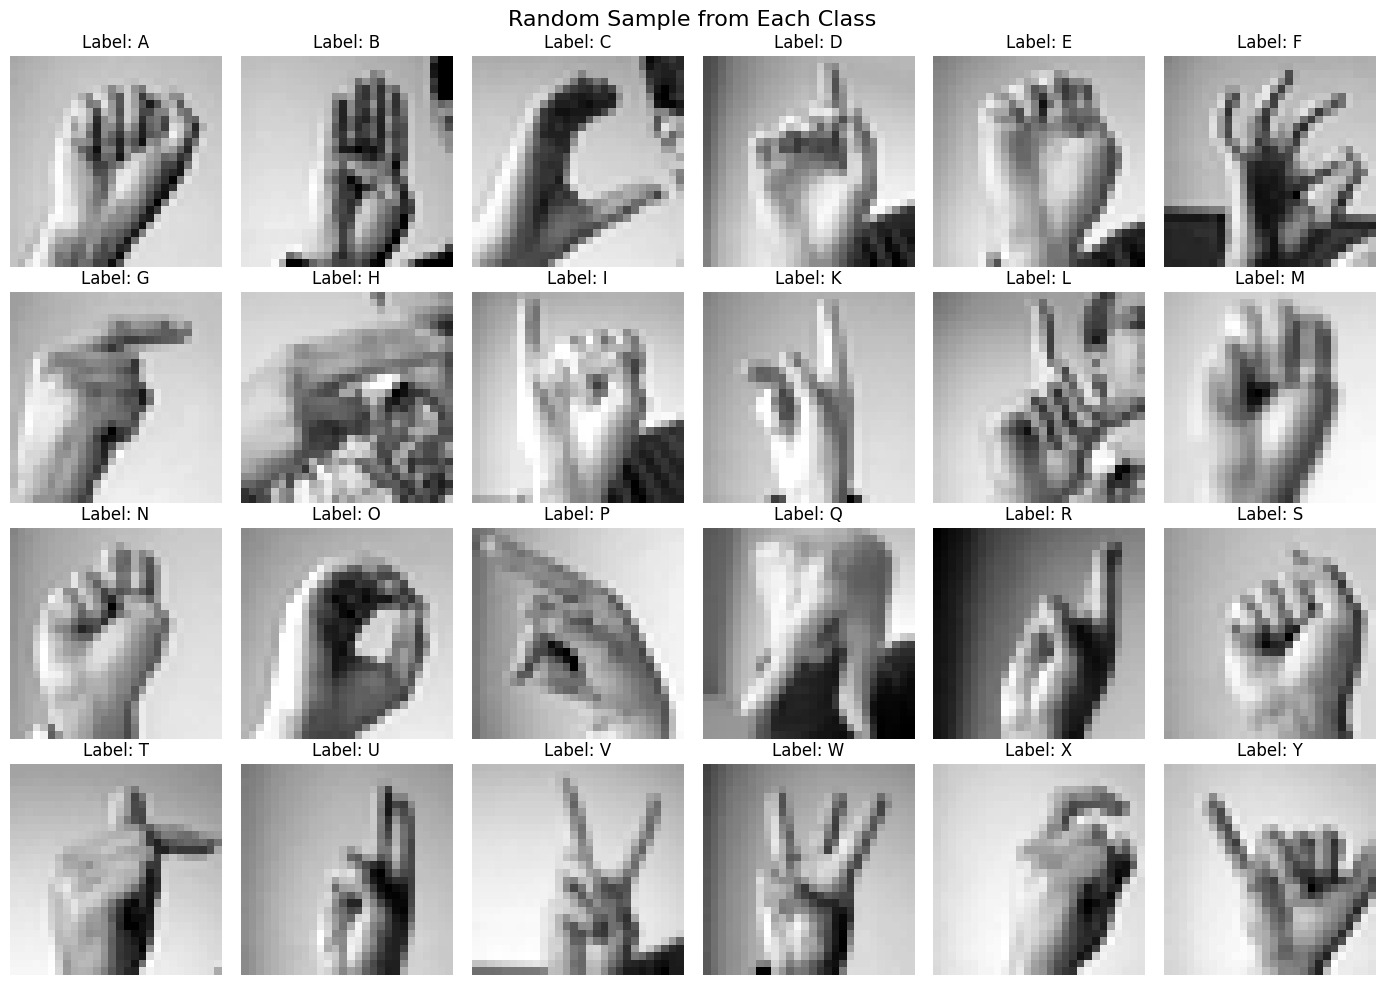

In [118]:
display_random_samples_from_csv("/content/drive/MyDrive/ASL-Project/mnist_28x28.csv", image_size=(28, 28))


In [119]:
export_resized_mnist_csv(mnist_df, "/content/drive/MyDrive/ASL-Project/mnist_64x64.csv", samples_per_class=60, image_size=(64, 64))


Resized MNIST CSV saved to: /content/drive/MyDrive/ASL-Project/mnist_64x64.csv


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0        A     181     181     181     181     181     181     181     180   
1        A     188     188     188     188     189     190     191     191   
2        A     218     218     219     220     221     223     223     224   
3        A     174     174     175     176     176     176     176     175   
4        A     173     173     174     175     175     175     175     175   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
1435     Y     136     136     138     140     142     143     145     147   
1436     Y     170     170     170     171     172     173     173     174   
1437     Y     104     105     107     109     110     111     112     114   
1438     Y     188     188     189     189     189     190     191     191   
1439     Y     141     141     142     143     144     145     146     148   

      pixel9  ...  pixel4087  pixel4088  pixel4089  pixel4090  pixel4091  \
0        180  ...        182        182        182        181        181   
1        192  ...        232        232        232        232        233   
2        224  ...        133        136        142        149        146   
3        175  ...        202        202        202        204        205   
4        175  ...        201        198        199        202        206   
...      ...  ...        ...        ...        ...        ...        ...   
1435     149  ...        165        186        196        193        191   
1436     175  ...        206        207        207        207        207   
1437     116  ...         78         78         78         79         79   
1438     192  ...        214        214        213        212        211   
1439     149  ...        184        183        181        180        179   

      pixel4092  pixel4093  pixel4094  pixel4095  pixel4096  
0           180        179        178        177        177  
1           232        232        232        232        232  
2           107         68         52         38         33  
3           204        203        202        201        201  
4           211        216        216        215        215  
...         ...        ...        ...        ...        ...  
1435        185        179        169        159        156  
1436        206        206        206        206        206  
1437         77         76         76         75         75  
1438        211        211        210        210        210  
1439        177        176        175        175        175  

[1440 rows x 4097 columns]

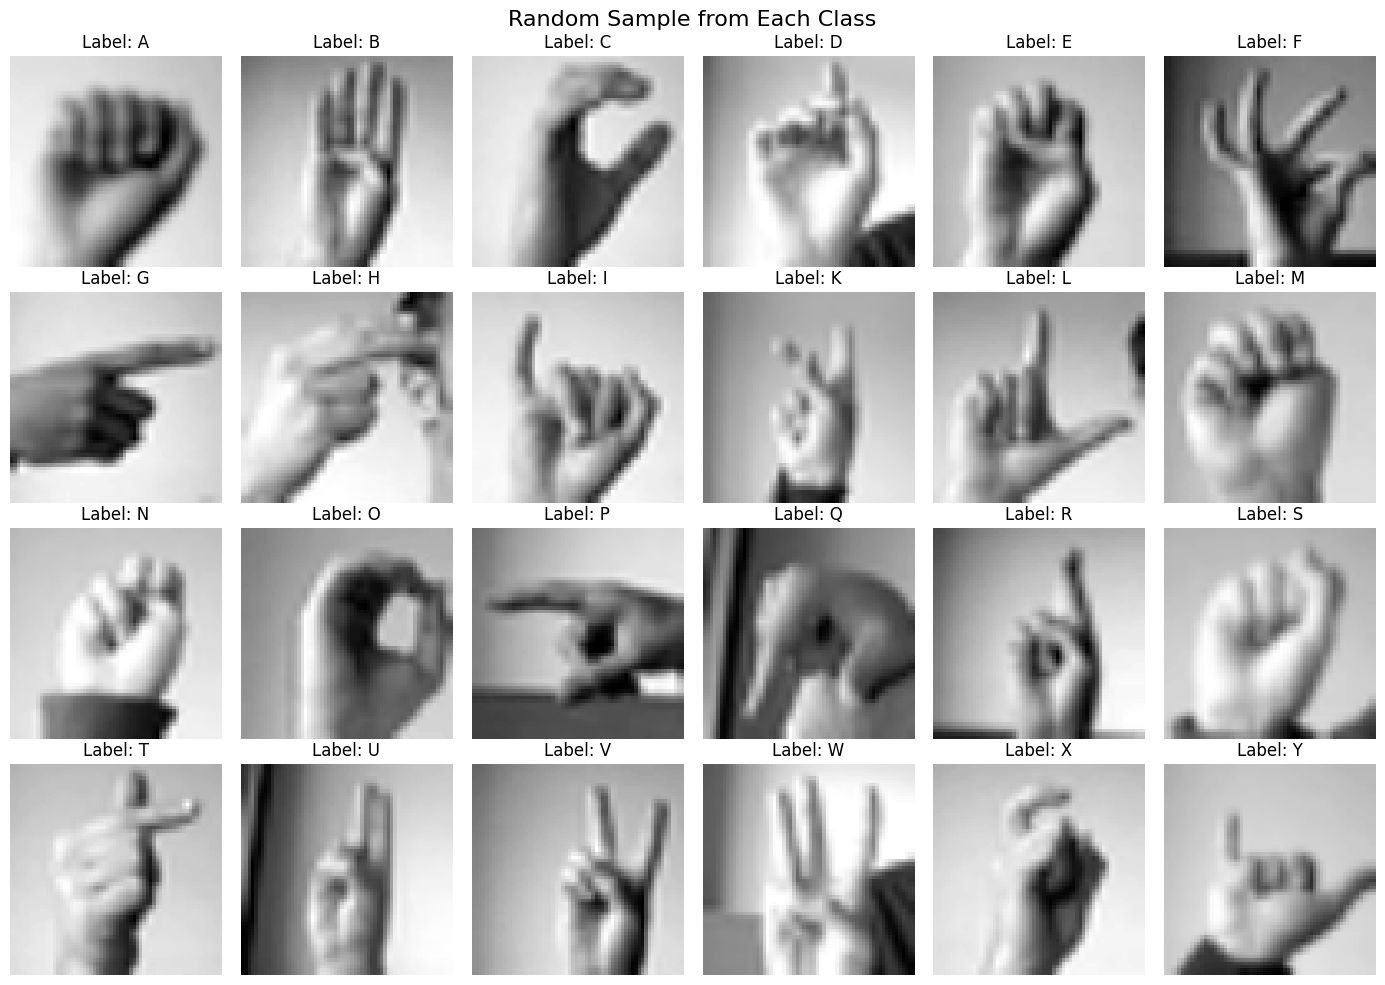

In [120]:
display_random_samples_from_csv("/content/drive/MyDrive/ASL-Project/mnist_64x64.csv", image_size=(64, 64))


In [121]:
export_resized_mnist_csv(mnist_df, "/content/drive/MyDrive/ASL-Project/mnist_224x224.csv", samples_per_class=60, image_size=(224, 224))


Resized MNIST CSV saved to: /content/drive/MyDrive/ASL-Project/mnist_224x224.csv


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0        A     181     181     181     181     181     181     181     181   
1        A     188     188     188     188     188     188     188     188   
2        A     218     218     218     218     218     218     218     219   
3        A     174     174     174     174     174     174     174     175   
4        A     173     173     173     173     173     173     173     174   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
1435     Y     136     136     136     136     136     137     137     138   
1436     Y     170     170     170     170     170     170     170     170   
1437     Y     104     104     104     104     104     105     105     106   
1438     Y     188     188     188     188     188     188     188     188   
1439     Y     141     141     141     141     141     141     141     142   

      pixel9  ...  pixel50167  pixel50168  pixel50169  pixel50170  pixel50171  \
0        181  ...         178         178         178         177         177   
1        188  ...         232         232         232         232         232   
2        219  ...          55          51          47          43          39   
3        175  ...         202         202         202         201         201   
4        174  ...         216         216         216         216         215   
...      ...  ...         ...         ...         ...         ...         ...   
1435     138  ...         172         169         166         163         160   
1436     170  ...         206         206         206         206         206   
1437     107  ...          76          76          75          75          75   
1438     188  ...         211         210         210         210         210   
1439     142  ...         176         176         175         175         175   

      pixel50172  pixel50173  pixel50174  pixel50175  pixel50176  
0            177         177         177         177         177  
1            232         232         232         232         232  
2             35          33          33          33          33  
3            201         201         201         201         201  
4            215         215         215         215         215  
...          ...         ...         ...         ...         ...  
1435         157         156         156         156         156  
1436         206         206         206         206         206  
1437          75          75          75          75          75  
1438         210         210         210         210         210  
1439         175         175         175         175         175  

[1440 rows x 50177 columns]

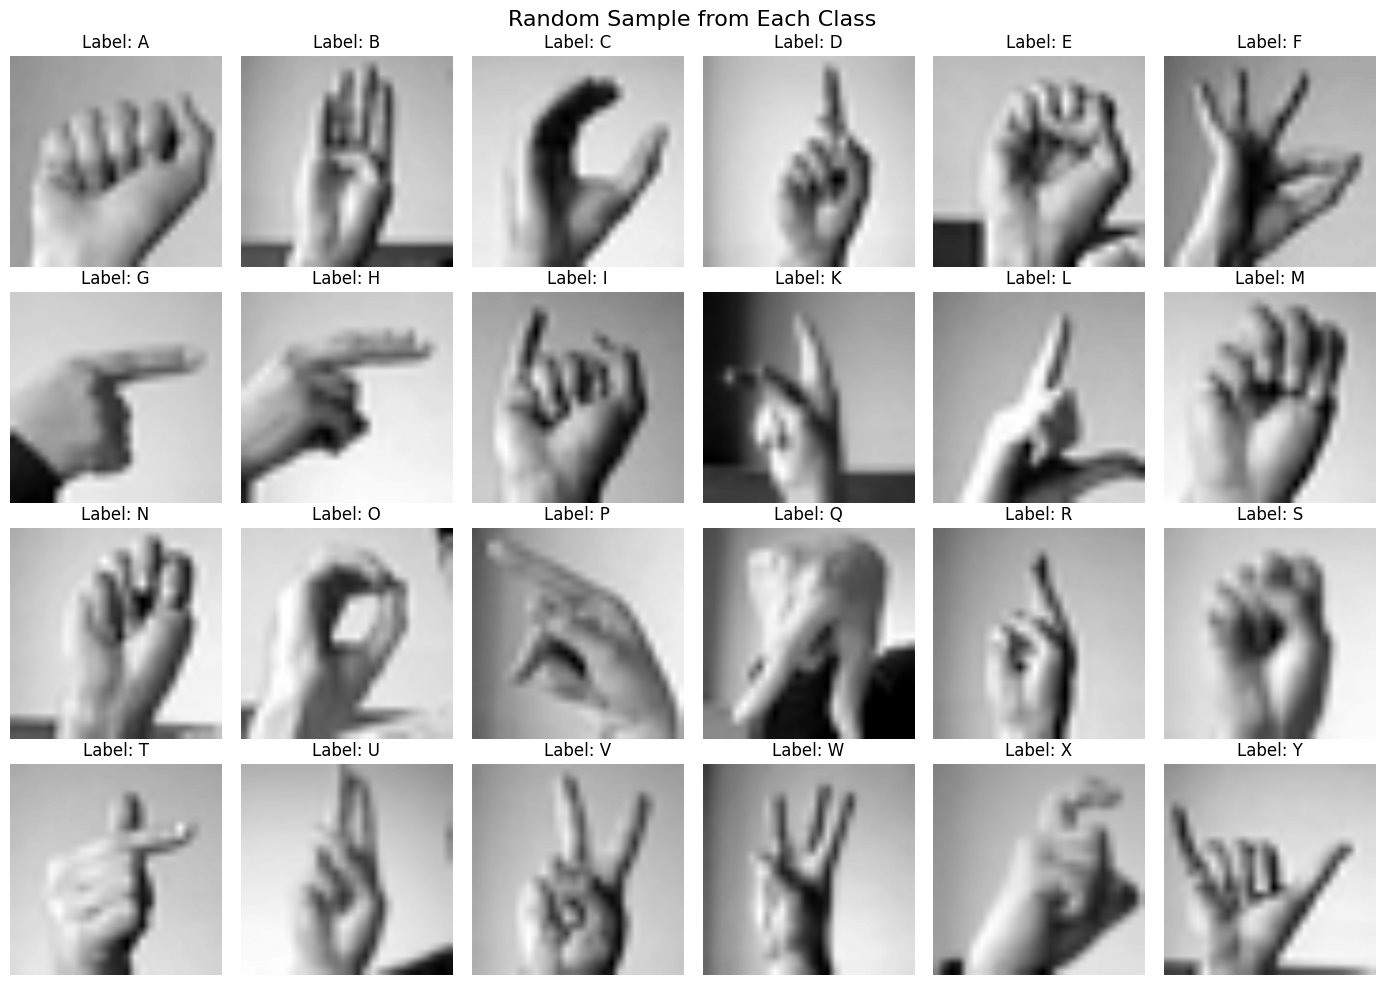

In [122]:
display_random_samples_from_csv("/content/drive/MyDrive/ASL-Project/mnist_224x224.csv", image_size=(224, 224))


# **Merging csvs**

In [123]:
def merge_and_shuffle_csvs(csv_paths, output_path):
    """
    Merges multiple MNIST-style CSVs and shuffles the final dataset.

    Args:
        csv_paths (list): List of CSV file paths to merge.
        output_path (str): File path to save the final merged CSV.

    Returns:
        pd.DataFrame: The shuffled, merged dataset.
    """
    dfs = [pd.read_csv(path) for path in csv_paths]
    merged_df = pd.concat(dfs, ignore_index=True)
    shuffled_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)
    shuffled_df.to_csv(output_path, index=False)
    print(f"Merged and shuffled dataset saved to: {output_path}")
    return shuffled_df


In [128]:
csv_paths_28 = [
    "/content/drive/MyDrive/ASL-Project/kaggle_grayscale_28x28.csv",
    "/content/drive/MyDrive/ASL-Project/mnist_28x28.csv",
    "/content/drive/MyDrive/ASL-Project/roboflow_28x28.csv"
]

merged_28 = merge_and_shuffle_csvs(csv_paths_28, "/content/drive/MyDrive/ASL-Project/master_grayscale_28x28.csv")


Merged and shuffled dataset saved to: /content/drive/MyDrive/ASL-Project/master_grayscale_28x28.csv


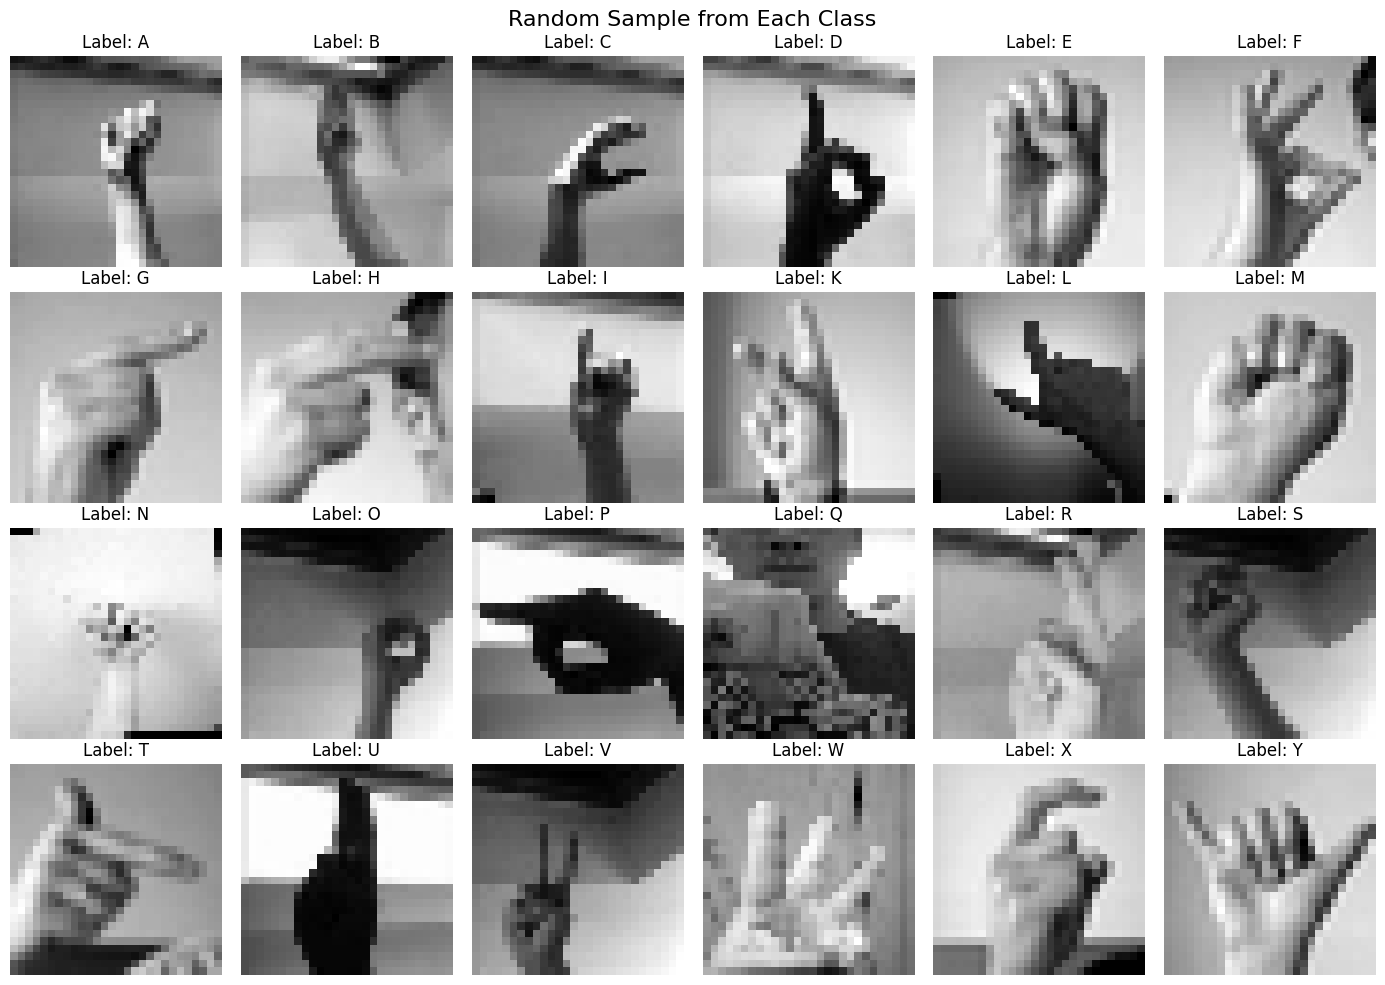

In [129]:
display_random_samples_from_csv("/content/drive/MyDrive/ASL-Project/master_grayscale_28x28.csv", image_size=(28, 28))


In [130]:
csv_paths_64 = [
    "/content/drive/MyDrive/ASL-Project/kaggle_64x64.csv",
    "/content/drive/MyDrive/ASL-Project/mnist_64x64.csv",
    "/content/drive/MyDrive/ASL-Project/roboflow_64x64.csv"
]

merged_64 = merge_and_shuffle_csvs(csv_paths_64, "/content/drive/MyDrive/ASL-Project/master_grayscale_64x64.csv")

Merged and shuffled dataset saved to: /content/drive/MyDrive/ASL-Project/master_grayscale_64x64.csv


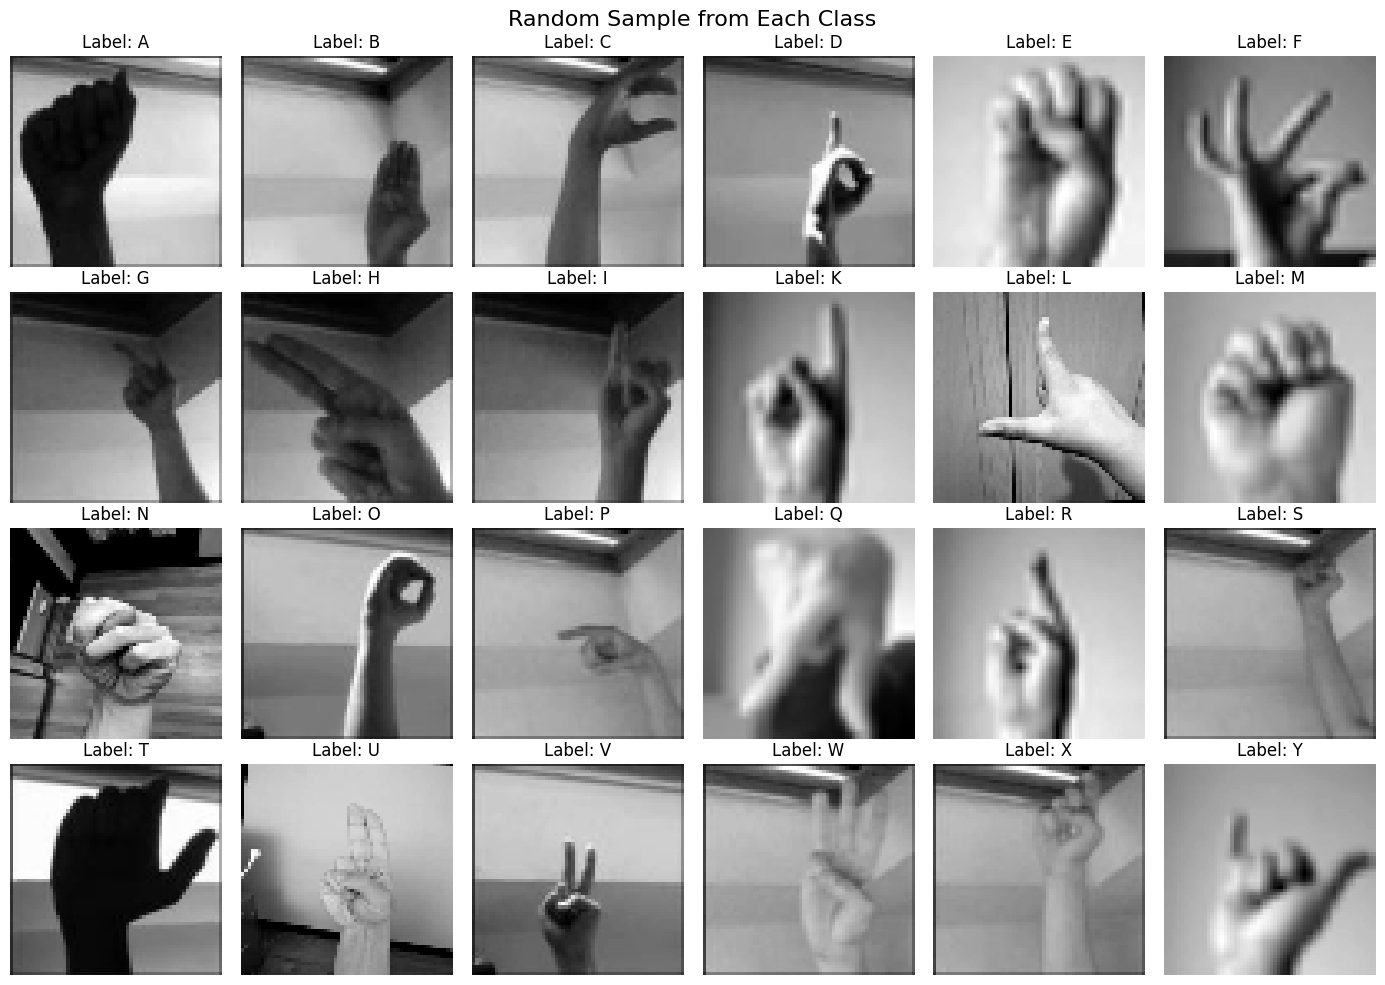

In [131]:
display_random_samples_from_csv("/content/drive/MyDrive/ASL-Project/master_grayscale_64x64.csv", image_size=(64, 64))


In [132]:
csv_paths_224 = [
    "/content/drive/MyDrive/ASL-Project/kaggle_224x224.csv",
    "/content/drive/MyDrive/ASL-Project/mnist_224x224.csv",
    "/content/drive/MyDrive/ASL-Project/roboflow_224x224.csv"
]

merged_224 = merge_and_shuffle_csvs(csv_paths_224, "/content/drive/MyDrive/ASL-Project/master_grayscale_224x224.csv")

Merged and shuffled dataset saved to: /content/drive/MyDrive/ASL-Project/master_grayscale_224x224.csv


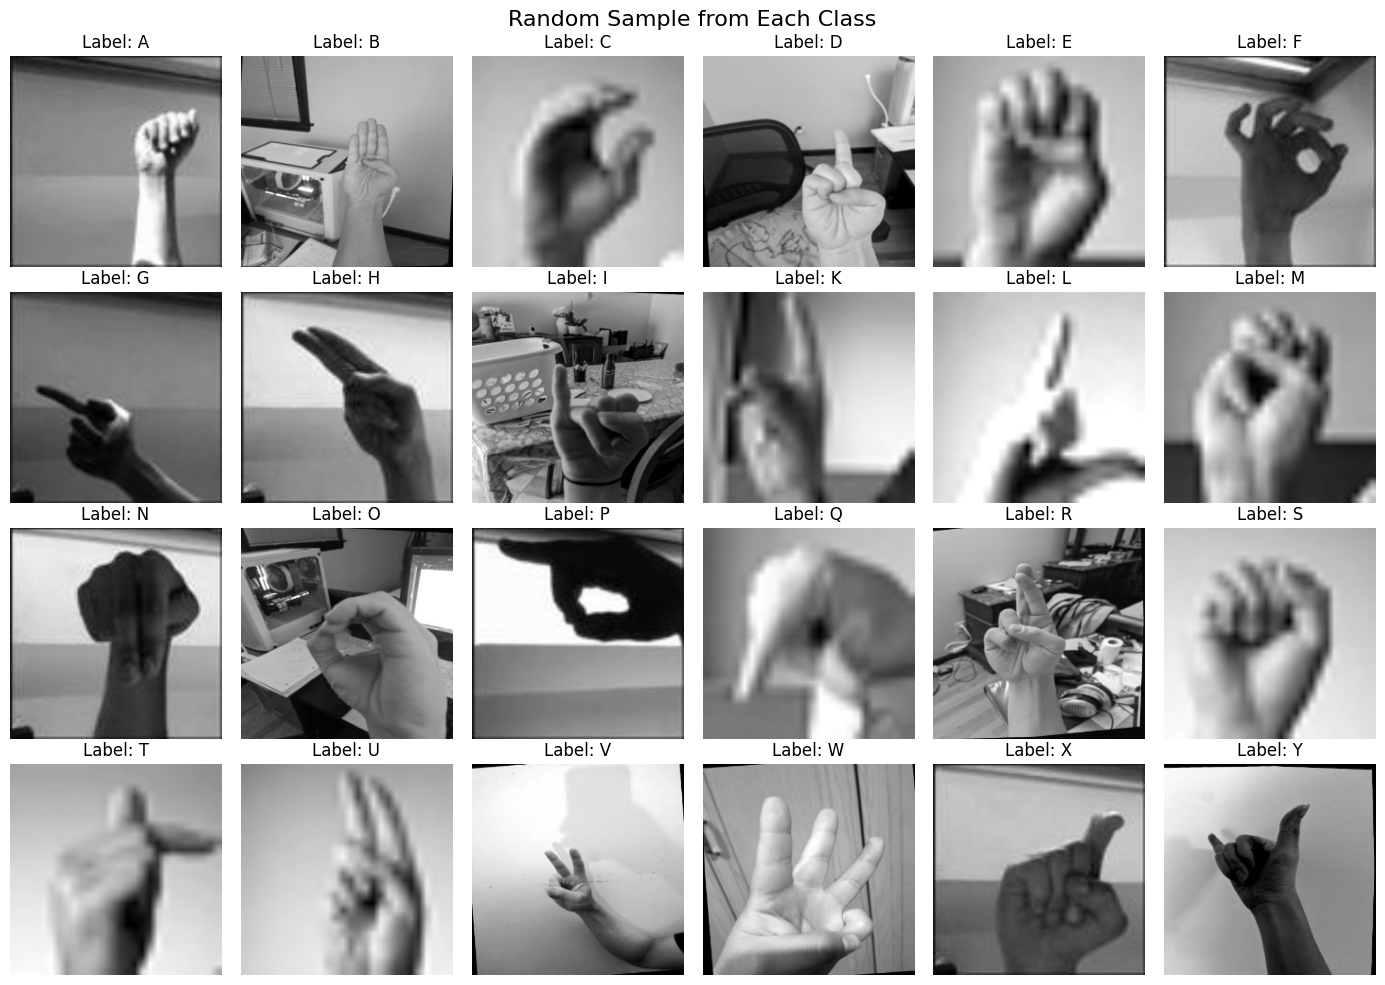

In [133]:
display_random_samples_from_csv("/content/drive/MyDrive/ASL-Project/master_grayscale_224x224.csv", image_size=(224, 224))
